In [1]:
from mobster_mv import mobster_MV
from plot_functions import plot_marginals, plot_deltas, plot_paretos, plot_betas
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component, only_pareto_binomial_component
import numpy as np
import pandas as pd
import pyro.distributions as dist
from BoundedPareto import BoundedPareto
from scipy.stats import pareto, beta, uniform, norm, lognorm



import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings


%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [3]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, probs_beta, a_beta, b_beta, weights):
    return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, probs_pareto, alpha, weights):
    return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        probs_beta = mb.params["probs_beta"][k, dim]
        return log_sum_exp(beta_lk(NV, DP, probs_beta, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, probs_pareto, alpha, weights)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [4]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


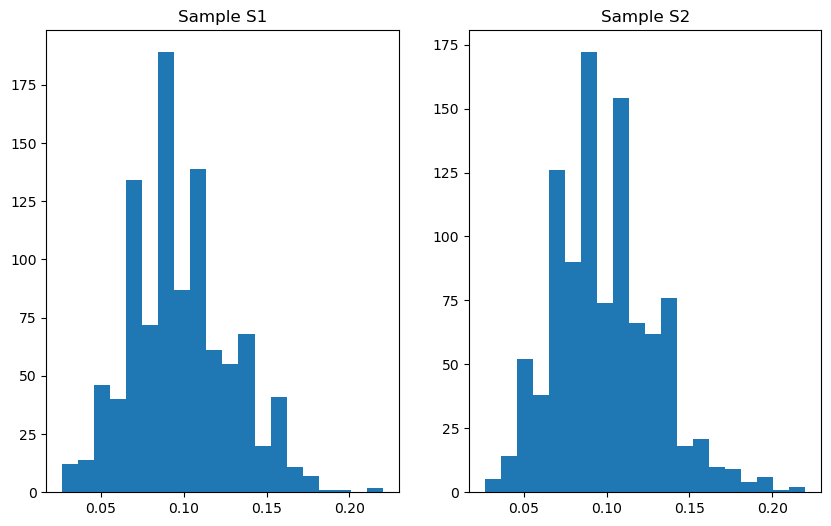

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [6]:
labels = np.zeros(N1)

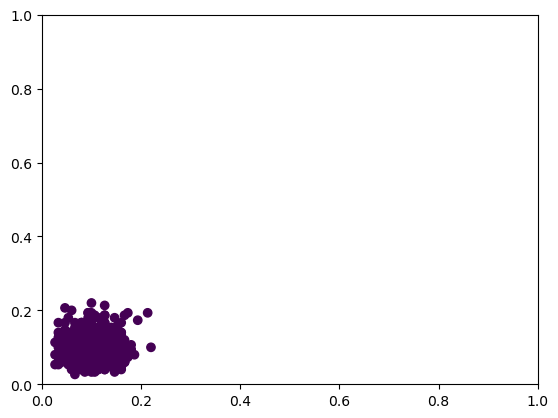

In [7]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0986, 0.0994]])
Iteration 0: Loss = -6599.3681640625
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.3586, 0.6414],
         [0.3318, 0.6682]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0987, 0.0995]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0986, 0.0994]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0986, 0.0994]], grad_fn=<AddBackward0>)


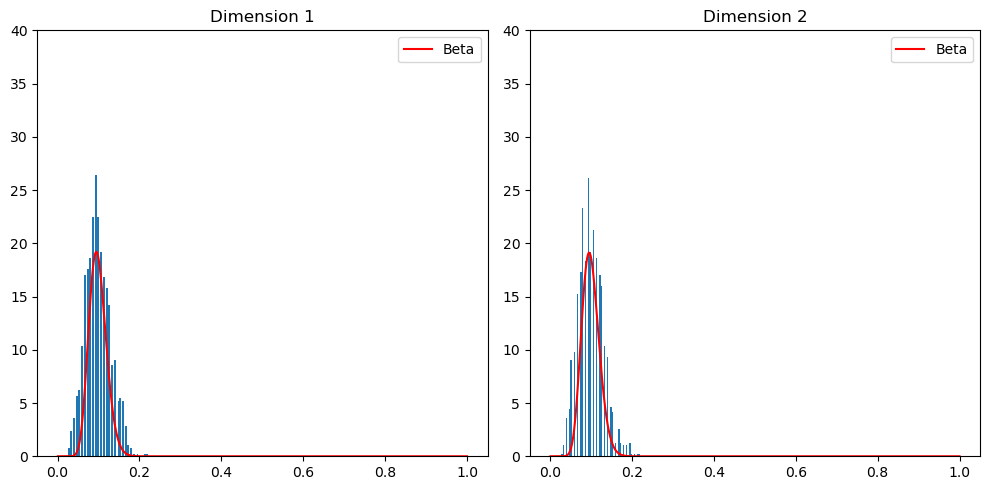

Iteration 200: Loss = -6939.05419921875
Iteration 400: Loss = -7101.30810546875
probs_beta [[0.08649284 0.08702575]]


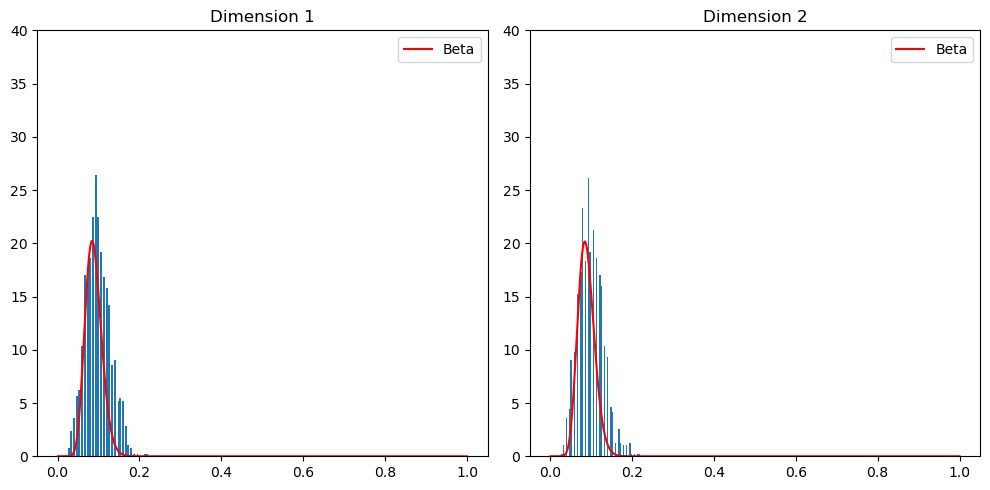

Iteration 600: Loss = -7208.47998046875
Iteration 800: Loss = -7283.83349609375
probs_beta [[0.08622938 0.08669143]]


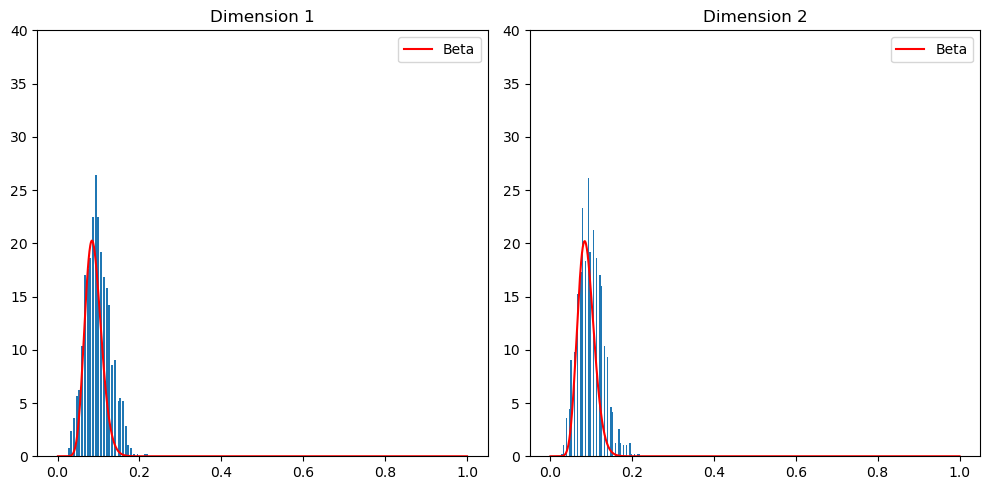

Iteration 1000: Loss = -7338.67919921875
Iteration 1200: Loss = -7379.06494140625
probs_beta [[0.08622922 0.08668905]]


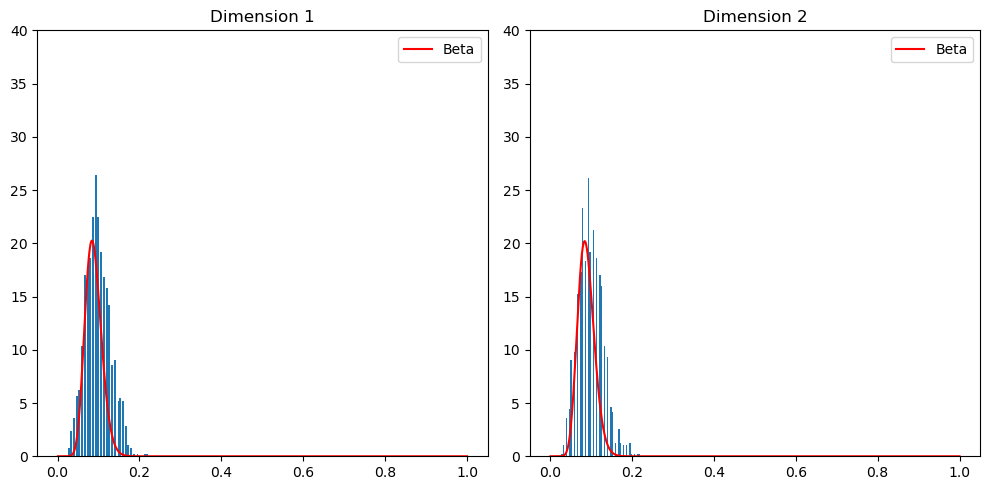

Iteration 1400: Loss = -7410.37744140625
Iteration 1600: Loss = -7434.6455078125
probs_beta [[0.08622929 0.0866869 ]]


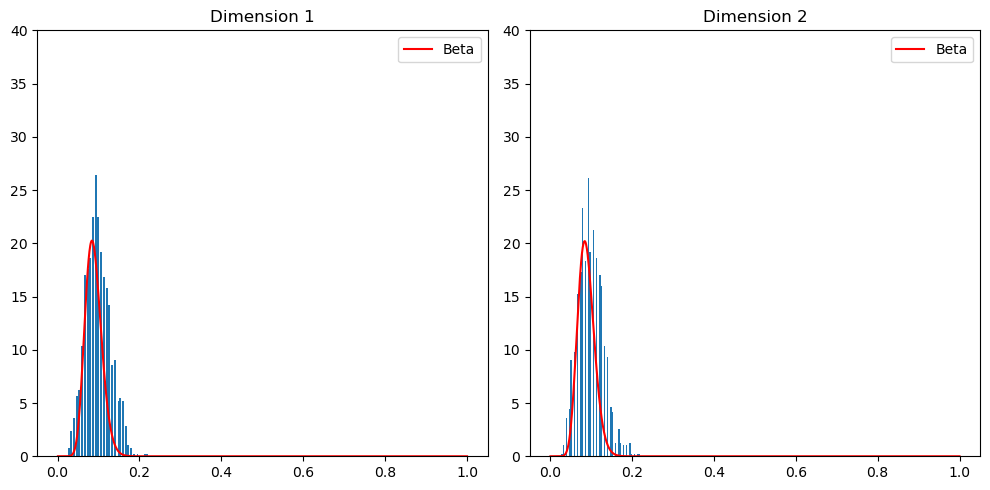

Iteration 1800: Loss = -7453.89892578125
Iteration 2000: Loss = -7469.552734375
probs_beta [[0.08622915 0.08668399]]


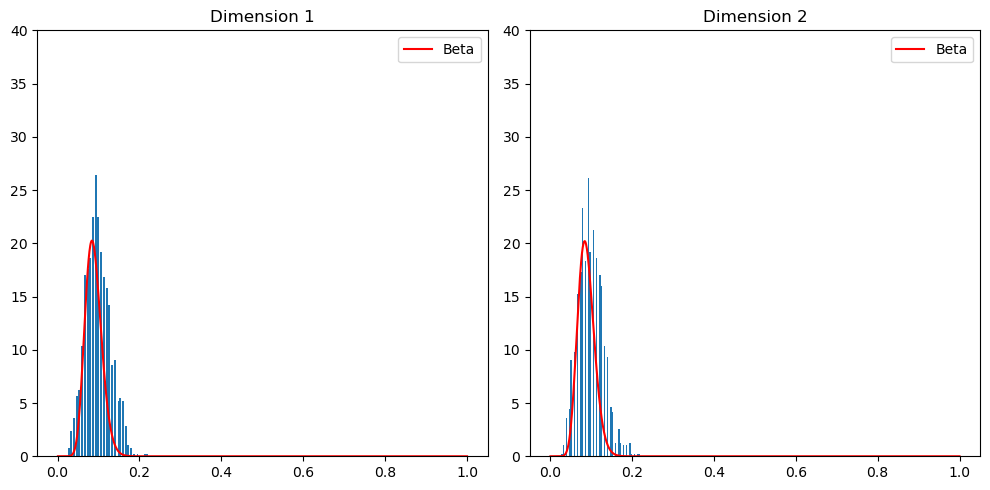

Iteration 2200: Loss = -7482.37548828125
Iteration 2400: Loss = -7492.998046875
probs_beta [[0.08622842 0.08668079]]


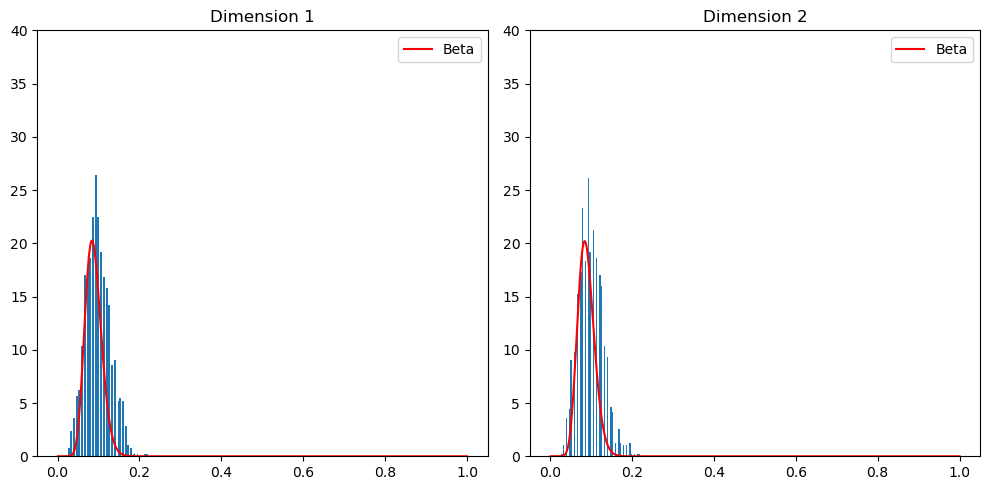

Iteration 2600: Loss = -7502.20263671875
Iteration 2800: Loss = -7510.0263671875
probs_beta [[0.08622761 0.08667862]]


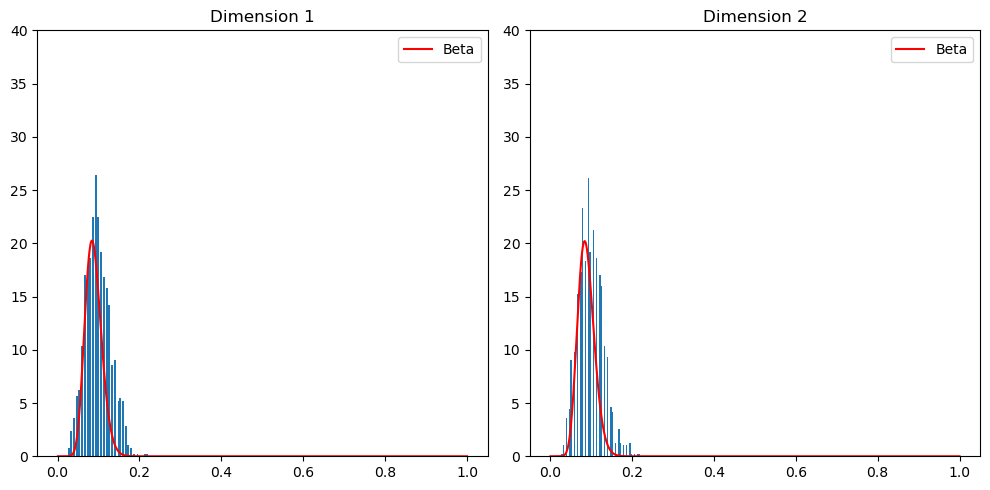

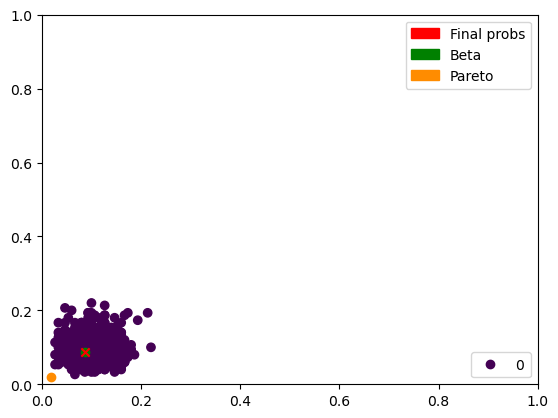

In [8]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [9]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(7.2213)
tensor(4.3006)
tensor(7.2184)
tensor(3.9156)


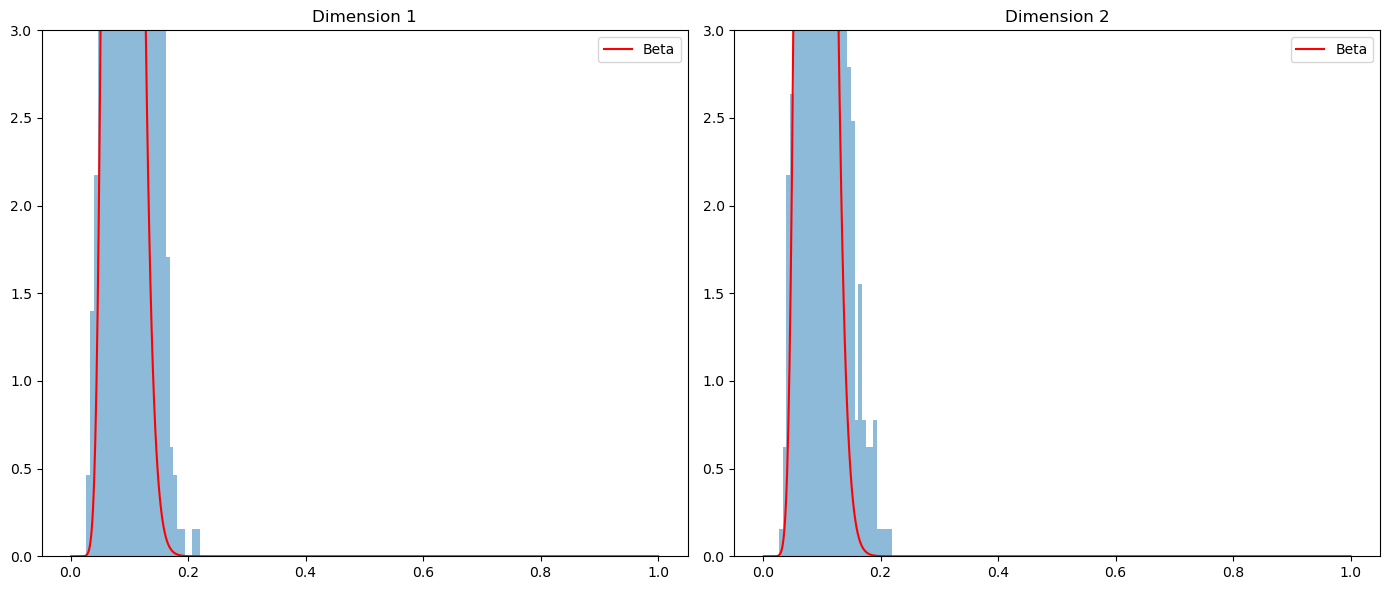

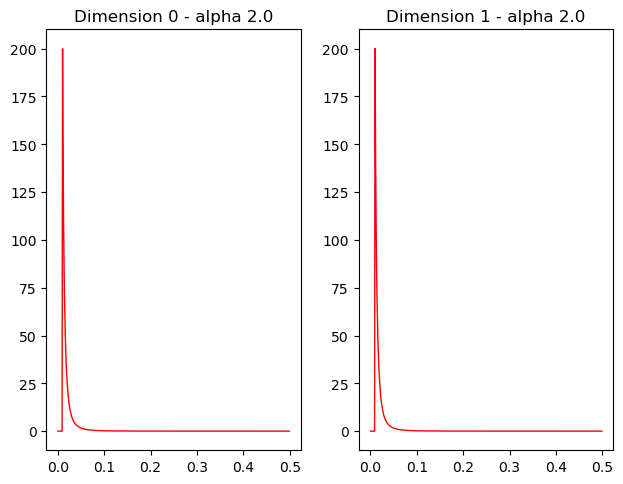

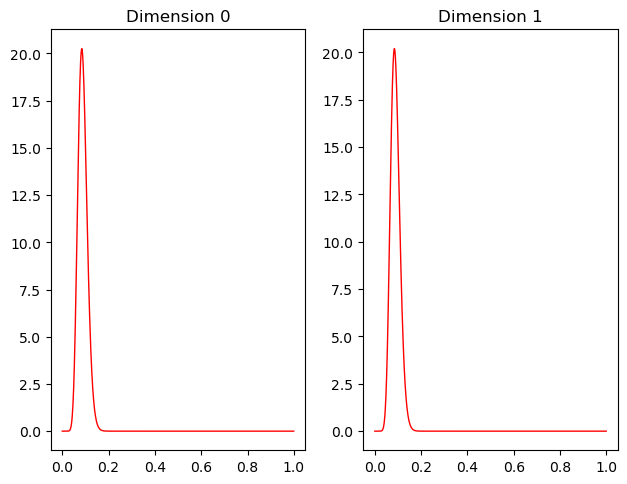

In [10]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [11]:
mb.params

{'probs_beta': tensor([[0.0862, 0.0867]]),
 'probs_pareto': tensor([[0.0179, 0.0191]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.0239, 0.9761],
          [0.0216, 0.9784]]]),
 'alpha_pareto': tensor([[2.0000, 2.0000]]),
 'phi_beta': tensor([[0.0883, 0.0887]]),
 'k_beta': tensor([[200.6225, 200.6223]]),
 'responsib': tensor([[0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.

Ho notato che inizialmente mette la pareto su entrambe le dimensioni, ma aumentando il numero di iterazioni il valore p della beta diminuisce finchè non arriva a 0.1 quindi il delta indica una beta. Aumentando ancora il numero di iterazioni la p però continua a scendere e quindi fitta nuovamente la pareto. BOH

### One pareto-pareto component

In [22]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [23]:
"""
NV = torch.ones([N1, 2]) # component 1
alpha_x=2
L_x=0.01
H_x=0.5
alpha_y=2
L_y=0.01
H_y=0.5
n=100
# x-axis component 1
NV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()
NV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()

DP = torch.ones([N1, 2]) * n
"""

'\nNV = torch.ones([N1, 2]) # component 1\nalpha_x=2\nL_x=0.01\nH_x=0.5\nalpha_y=2\nL_y=0.01\nH_y=0.5\nn=100\n# x-axis component 1\nNV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()\nNV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()\n\nDP = torch.ones([N1, 2]) * n\n'

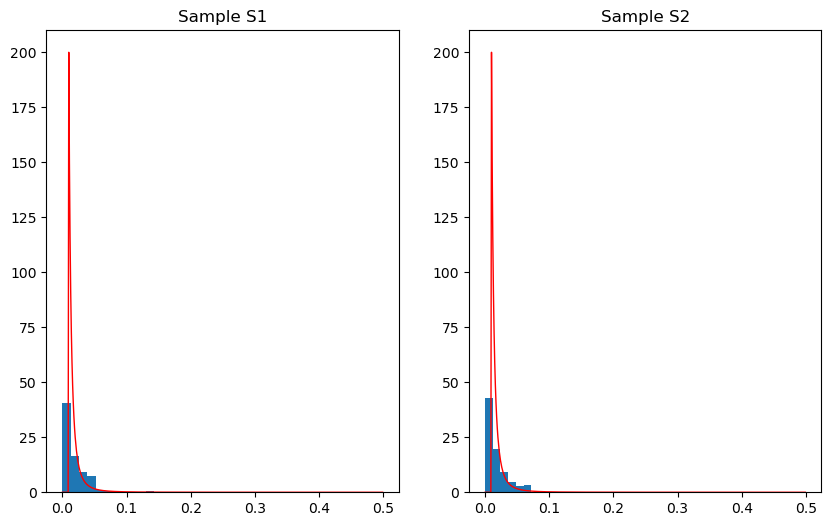

In [24]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

x = np.arange(0, 0.5, 0.001)
pdf = pareto.pdf(x, 2.0, scale=0.01)
axes[0].plot(x, pdf, 'r-', lw=1)

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
axes[1].plot(x, pdf, 'r-', lw=1)
plt.show()

In [25]:
labels = np.zeros(N1)

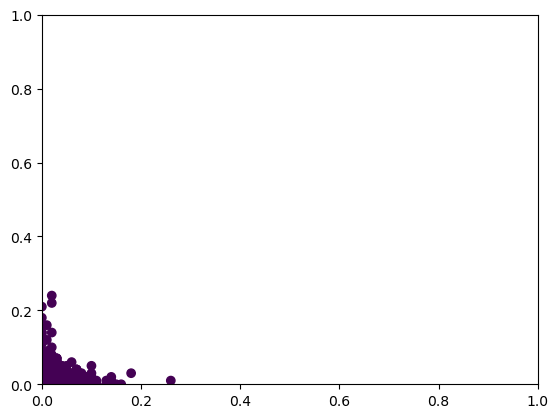

In [26]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.0195]])
Iteration 0: Loss = -10907.2958984375
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.3586, 0.6414],
         [0.3318, 0.6682]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0191, 0.0195]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)


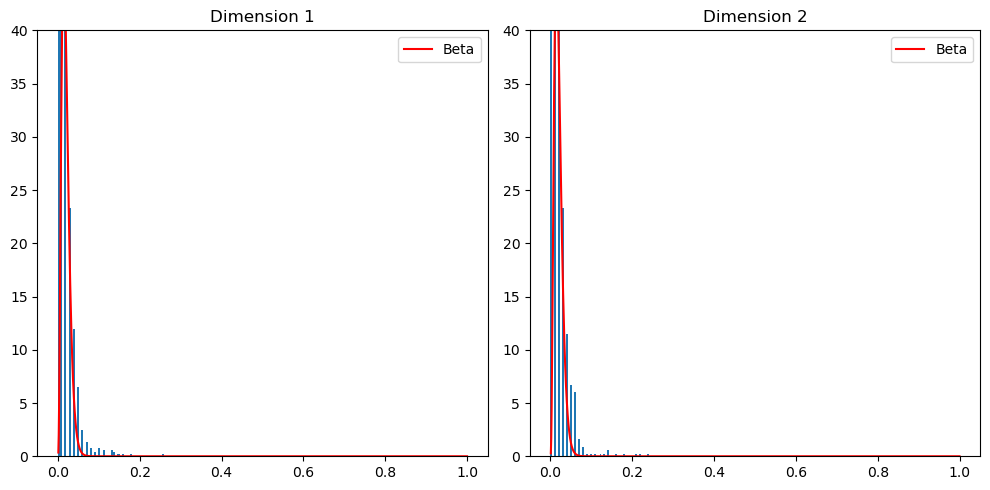

Iteration 200: Loss = -11568.1923828125
Iteration 400: Loss = -12686.4765625
probs_beta [[0.01447396 0.01465832]]


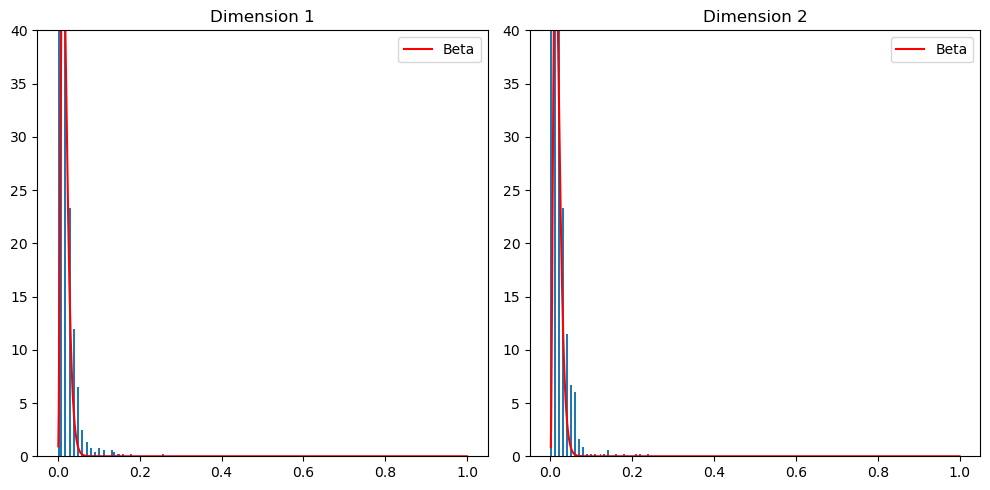

Iteration 600: Loss = -14577.974609375
Iteration 800: Loss = -16399.390625
probs_beta [[0.0135392  0.01360031]]


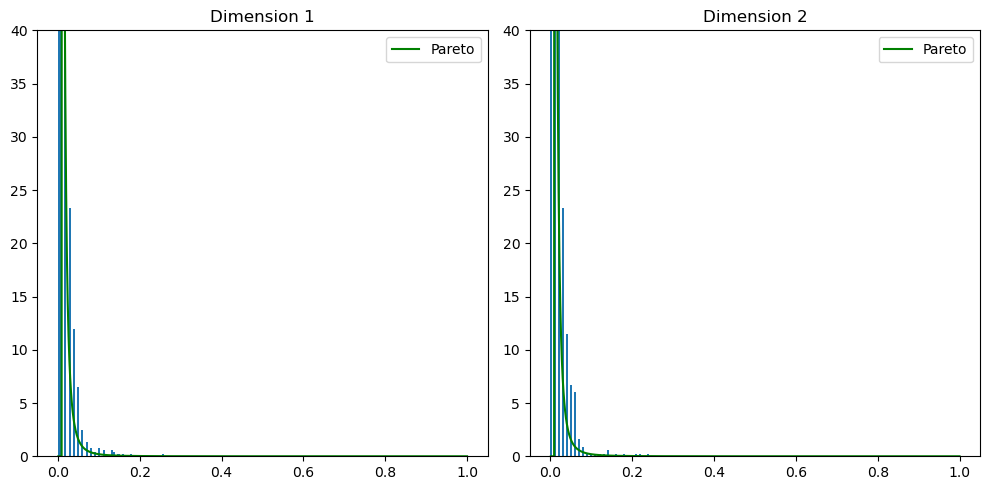

Iteration 1000: Loss = -18011.28125
Iteration 1200: Loss = -19485.078125
probs_beta [[0.01341561 0.01347029]]


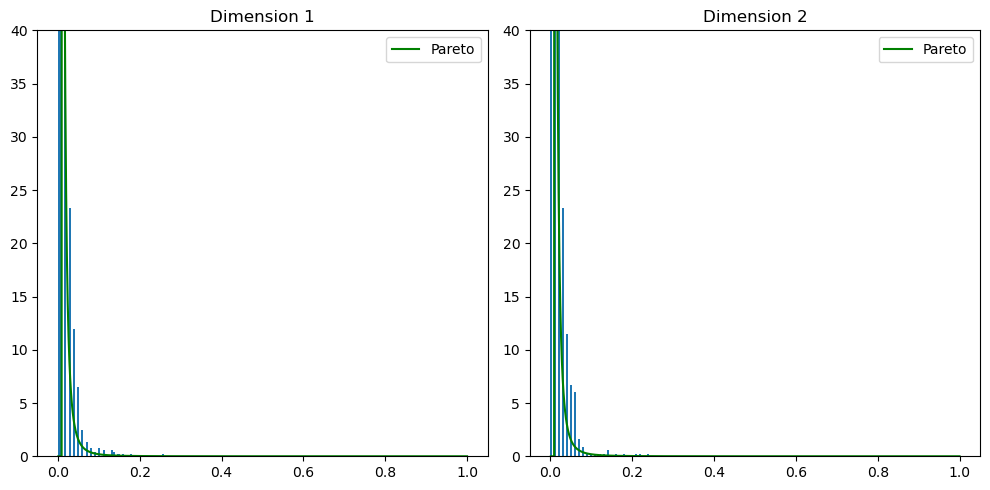

Iteration 1400: Loss = -20876.1484375
Iteration 1600: Loss = -22217.208984375
probs_beta [[0.01338389 0.01343856]]


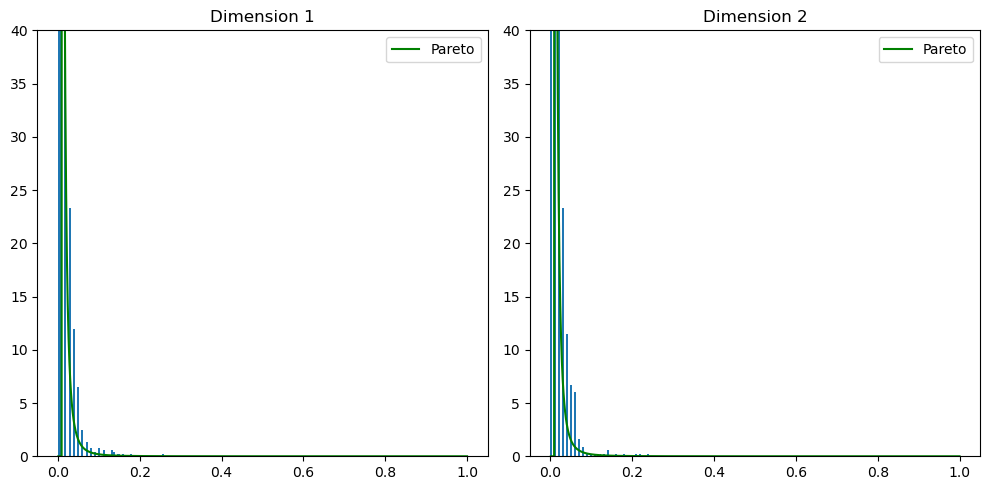

Iteration 1800: Loss = -23527.591796875
Iteration 2000: Loss = -24818.986328125
probs_beta [[0.01336569 0.01342122]]


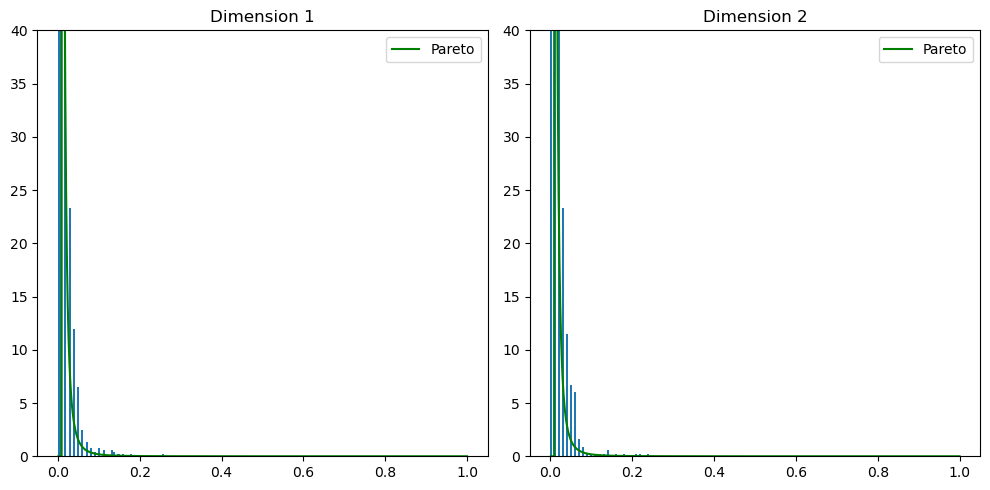

Iteration 2200: Loss = -26098.6328125
Iteration 2400: Loss = -27371.052734375
probs_beta [[0.01334752 0.01340424]]


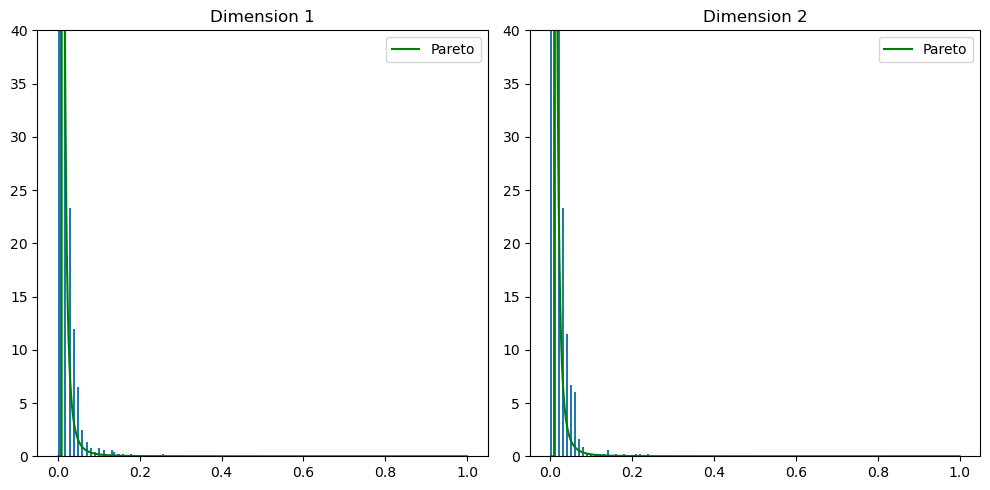

Iteration 2600: Loss = -28639.16796875
Iteration 2800: Loss = -29904.744140625
probs_beta [[0.01332592 0.01338407]]


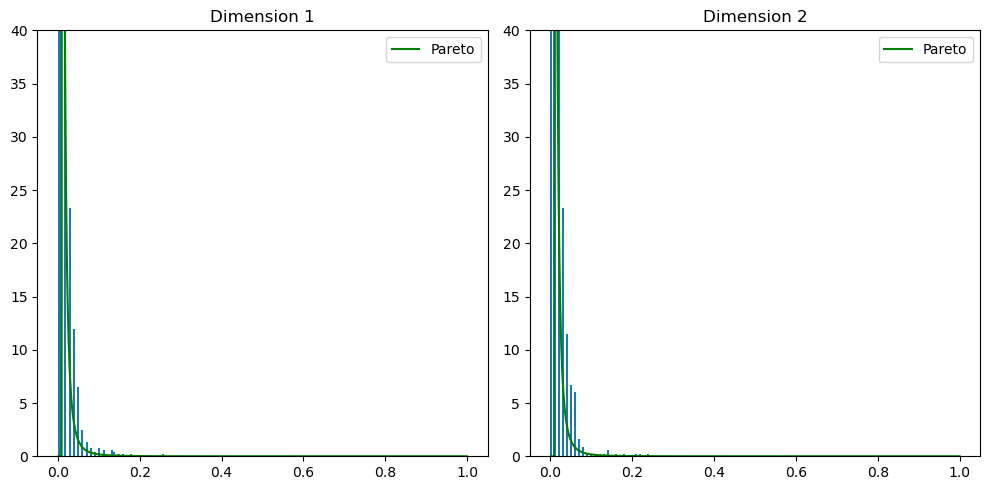

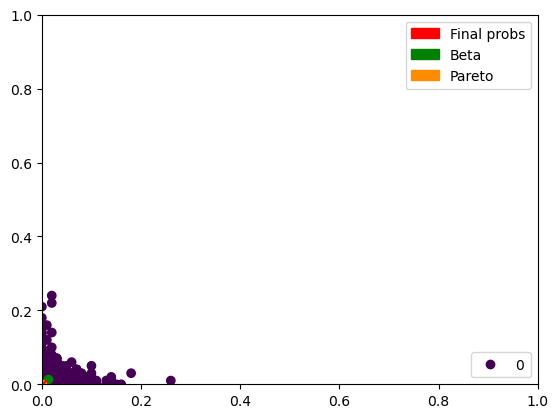

In [27]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [28]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(9.3511)
tensor(19.1728)
tensor(9.3482)
tensor(19.1961)


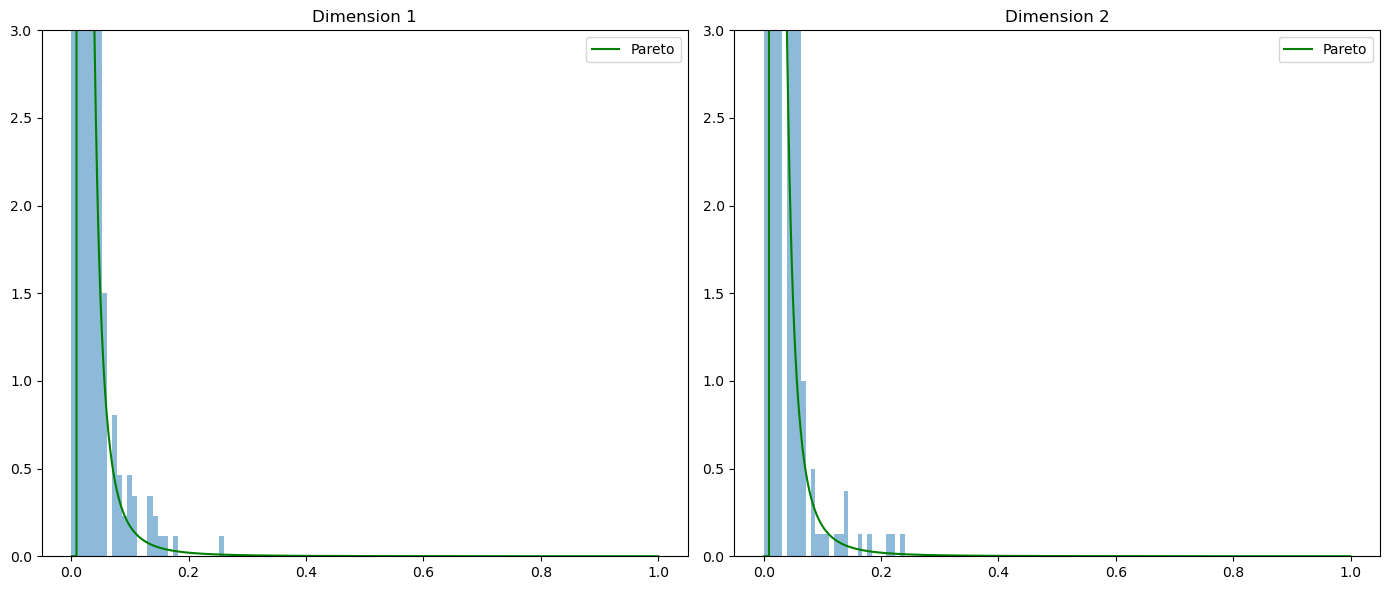

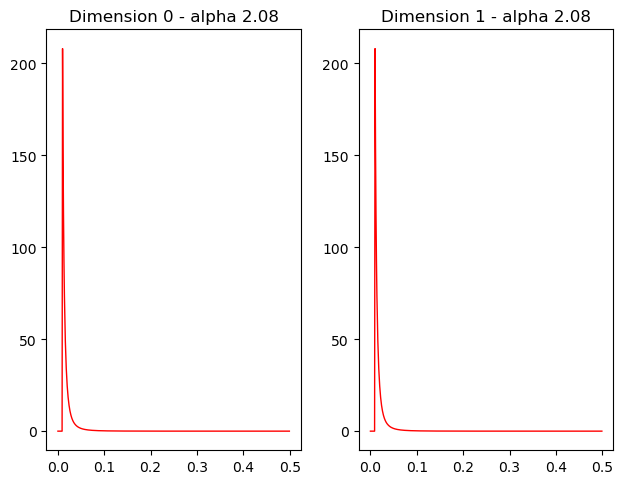

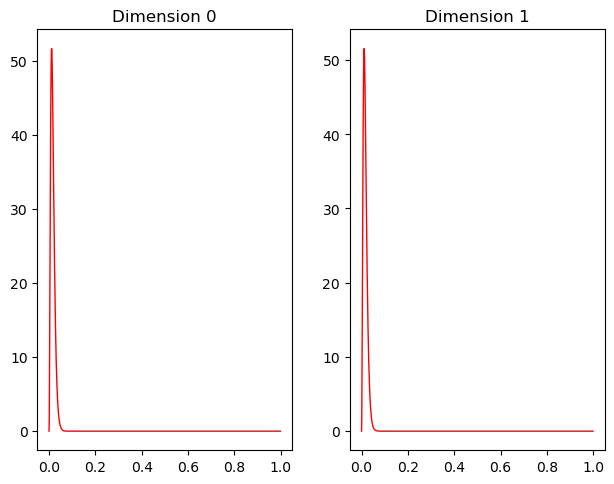

In [29]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [30]:
mb.params

{'probs_beta': tensor([[0.0133, 0.0134]]),
 'probs_pareto': tensor([[0.0007, 0.0006]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9712, 0.0288],
          [0.9681, 0.0319]]]),
 'alpha_pareto': tensor([[2.0804, 2.0809]]),
 'phi_beta': tensor([[0.0161, 0.0161]]),
 'k_beta': tensor([[200.0007, 200.0006]]),
 'responsib': tensor([[1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08, 1.1712e-08,
          1.1712e-08

### One beta-pareto component

In [14]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

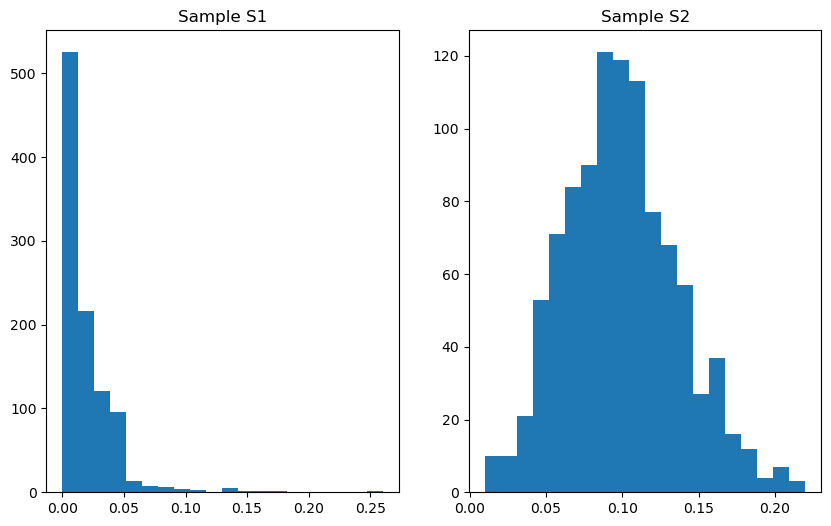

In [15]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [16]:
labels = np.zeros(N1)

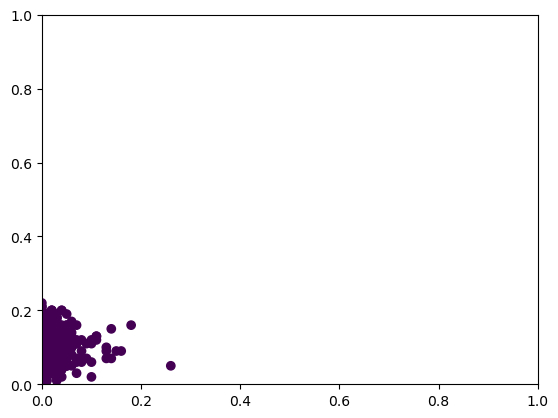

In [17]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.1002]])
Iteration 0: Loss = -9241.982421875
weights_param tensor([1.], grad_fn=<DivBackward0>)
delta_param tensor([[[0.0250, 0.9750],
         [0.2420, 0.7580]]], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9980, 1.9980]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0191, 0.1003]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.2001, 200.2001]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.0190, 0.1001]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0190, 0.1001]], grad_fn=<AddBackward0>)


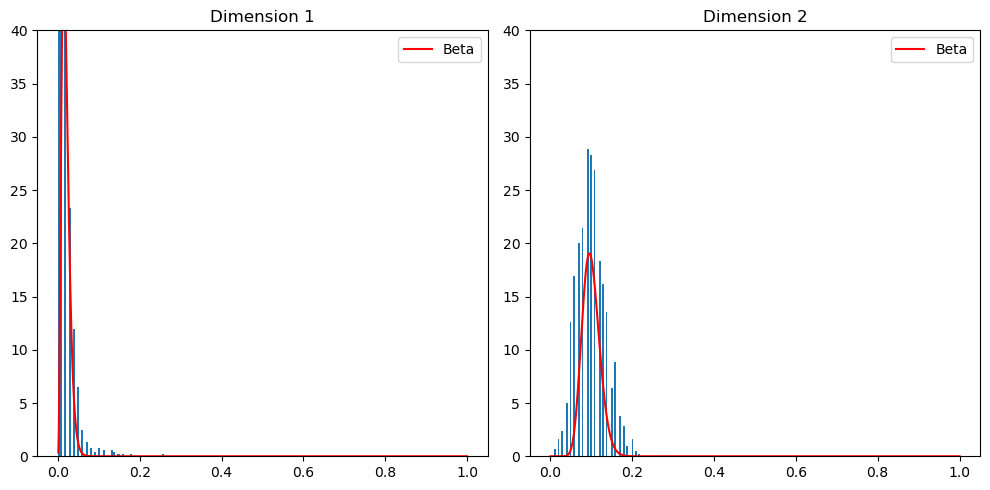

Iteration 200: Loss = -9570.3828125
Iteration 400: Loss = -9850.8076171875
probs_beta [[0.01391315 0.0845708 ]]


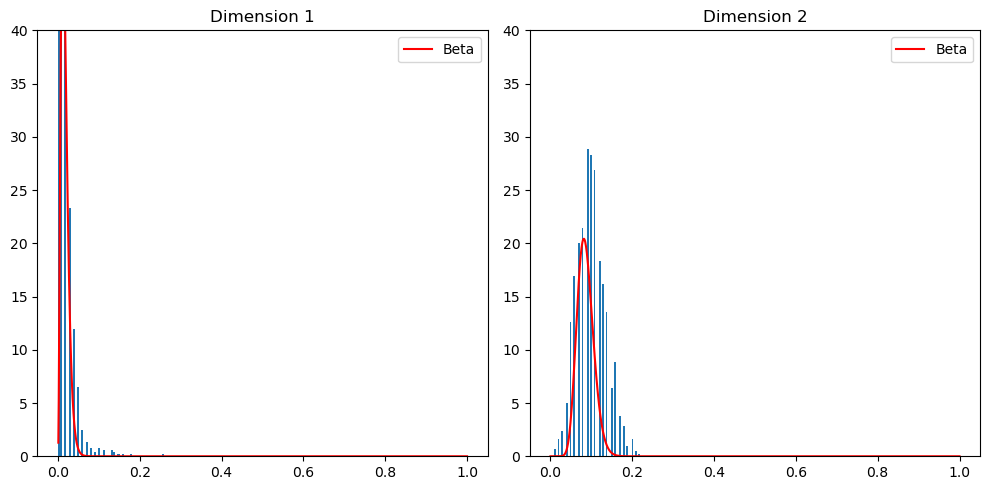

Iteration 600: Loss = -10806.8046875
Iteration 800: Loss = -12357.6357421875
probs_beta [[0.01201791 0.08133704]]


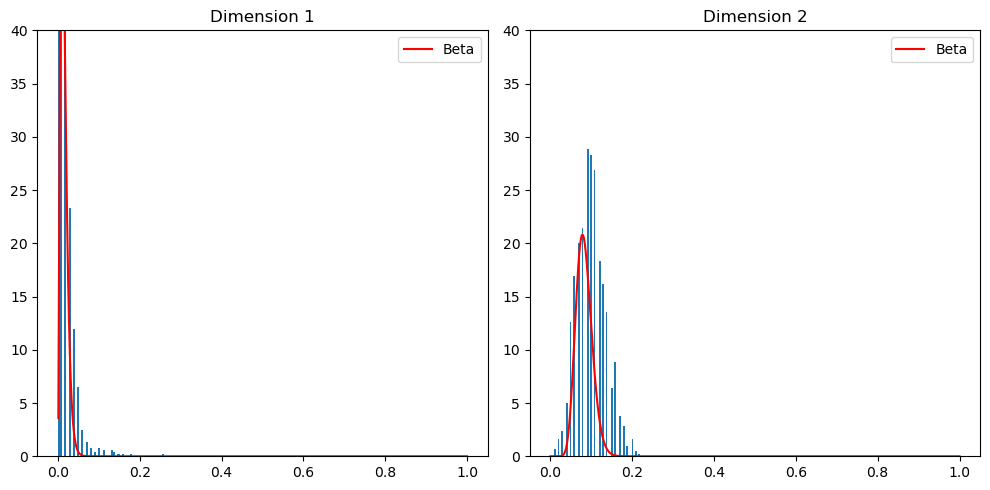

Iteration 1000: Loss = -13653.2646484375
Iteration 1200: Loss = -14716.564453125
probs_beta [[0.01188633 0.08077756]]


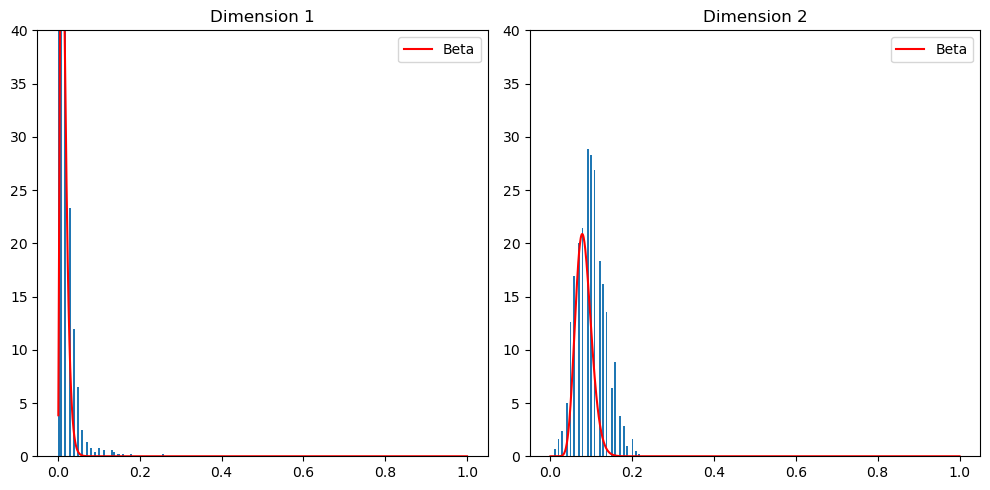

Iteration 1400: Loss = -15638.7177734375
Iteration 1600: Loss = -16472.775390625
probs_beta [[0.01186669 0.08075504]]


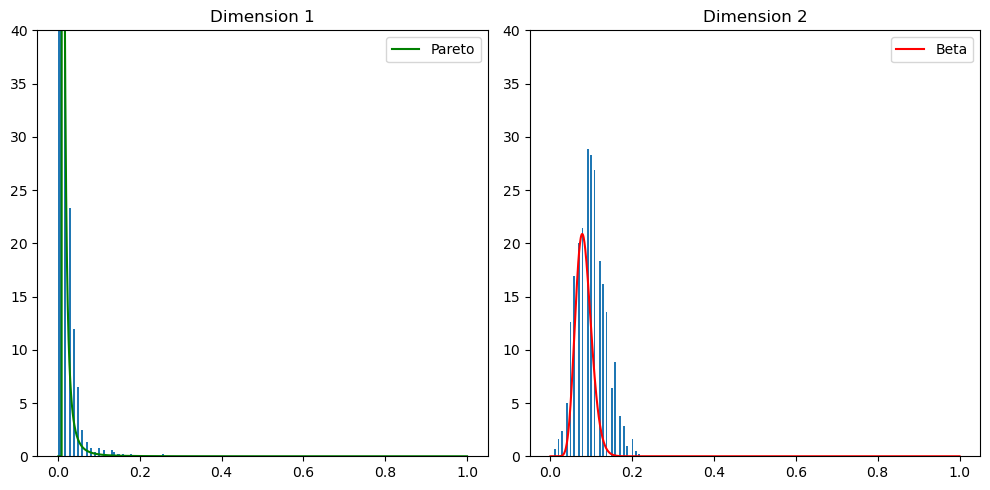

Iteration 1800: Loss = -17249.654296875
Iteration 2000: Loss = -17988.263671875
probs_beta [[0.01185704 0.08079376]]


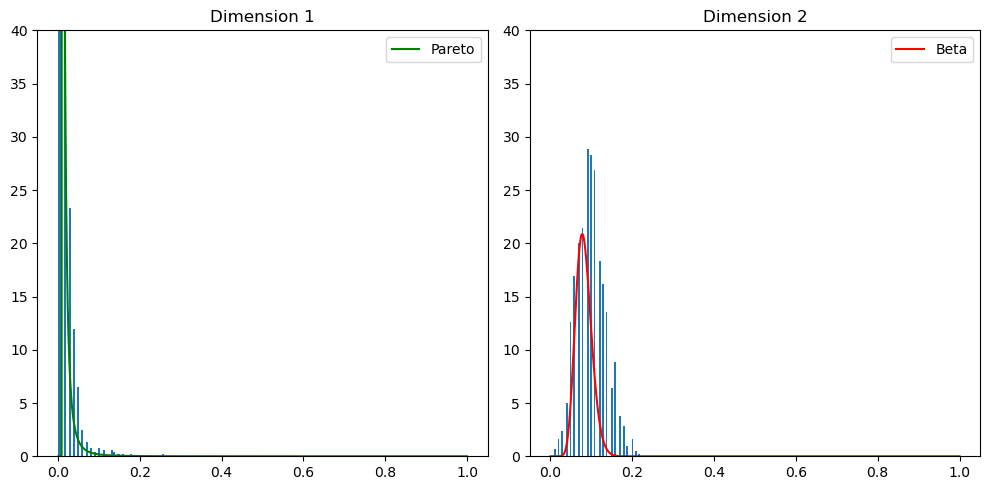

Iteration 2200: Loss = -18700.447265625
Iteration 2400: Loss = -19393.962890625
probs_beta [[0.0118471  0.08083712]]


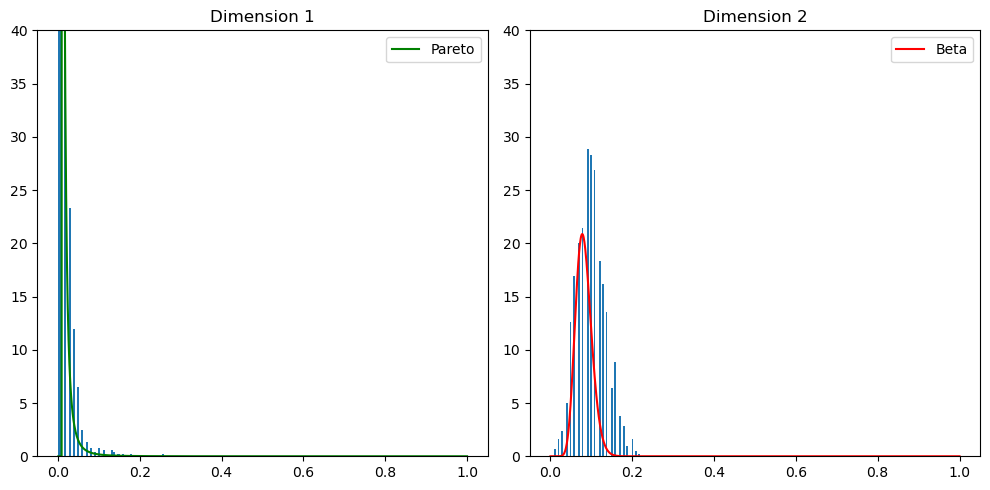

Iteration 2600: Loss = -20074.080078125
Iteration 2800: Loss = -20744.2578125
probs_beta [[0.01183521 0.08087308]]


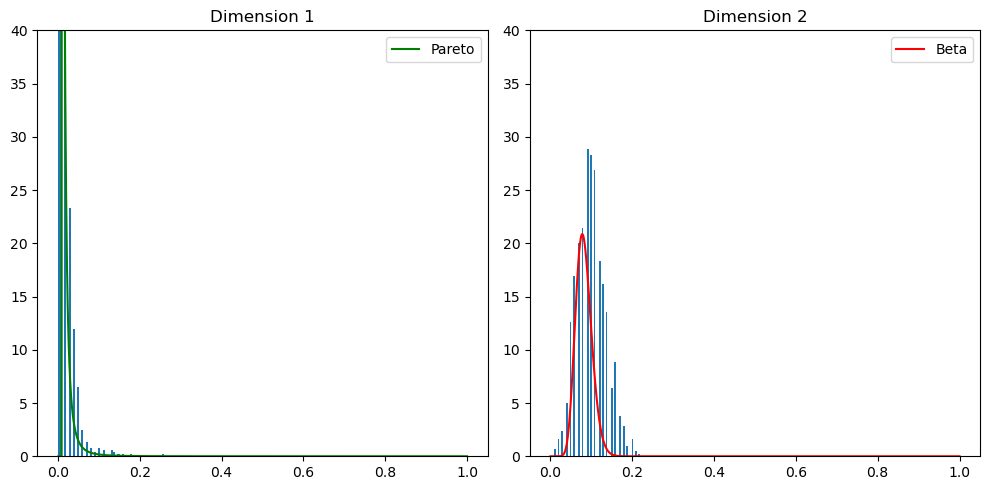

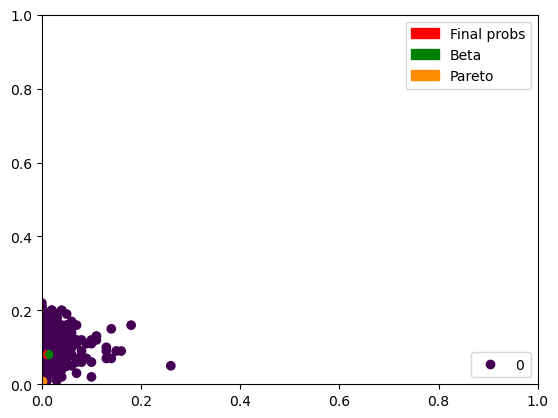

In [18]:
mb = mobster_MV(NV, DP, K = 1, seed = 153)
mb.fit(num_iter = 3000, lr = 0.001)

In [19]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(9.4345)
tensor(21.1137)
tensor(7.4563)
tensor(6.8646)


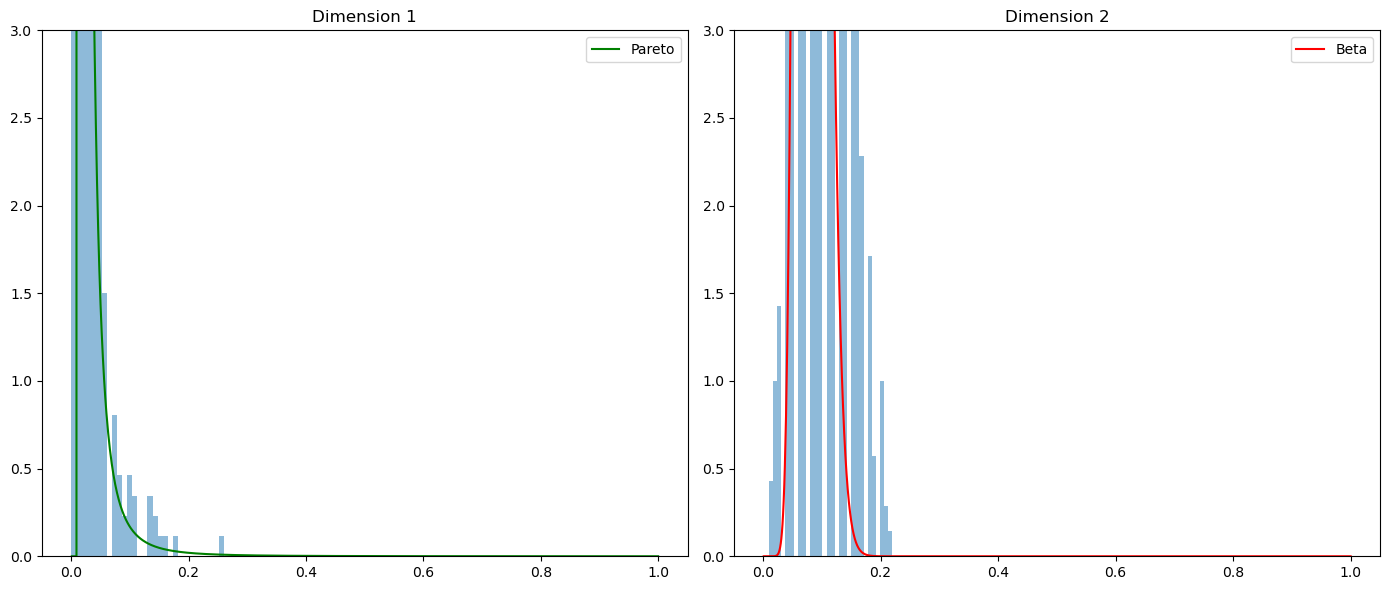

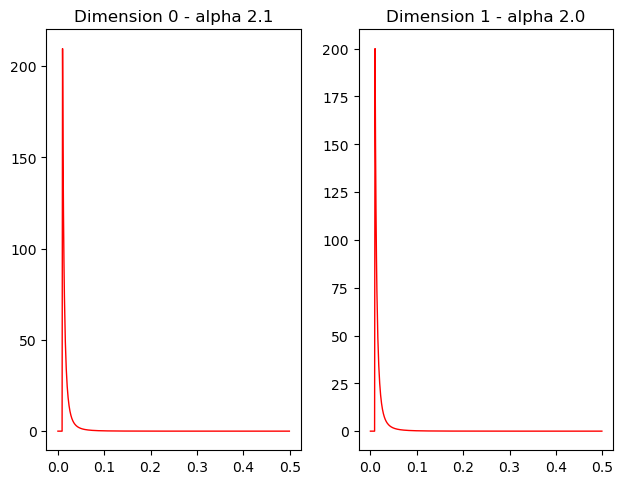

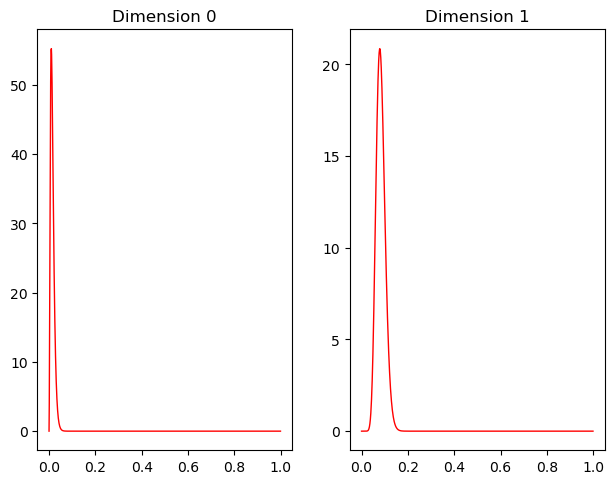

In [20]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [21]:
mb.params

{'probs_beta': tensor([[0.0118, 0.0809]]),
 'probs_pareto': tensor([[0.0004, 0.0084]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.8930, 0.1070],
          [0.0160, 0.9840]]]),
 'alpha_pareto': tensor([[2.0956, 2.0001]]),
 'phi_beta': tensor([[0.0146, 0.0830]]),
 'k_beta': tensor([[200.0004, 200.6206]]),
 'responsib': tensor([[0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
          0.0015, 0.

### 2 beta-pareto components

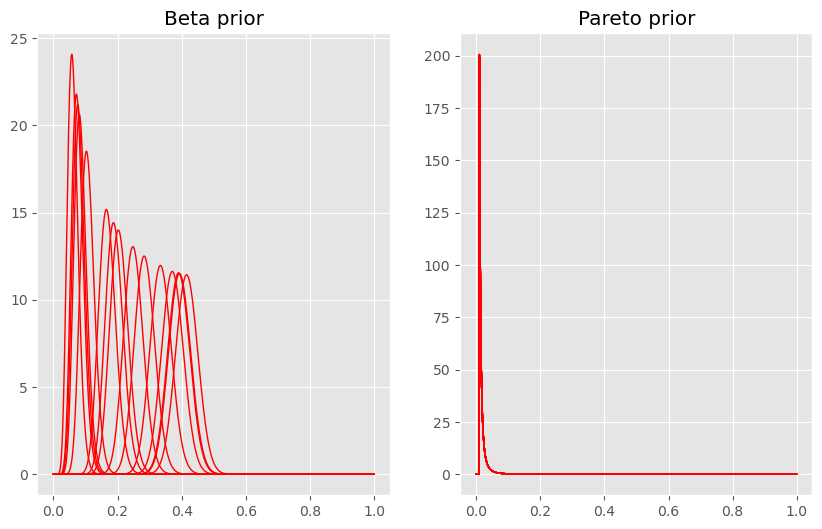

In [7]:
def plot_priors():
    # fig.tight_layout()
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    x = np.arange(0,1,0.001)
    for _ in range(15):
        phi_beta = dist.Uniform(0., 0.51).sample().numpy()
        k_beta = dist.Normal(200, 0.5).sample().numpy()
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        pdf = beta.pdf(x, a_beta, b_beta)
        axes[0].plot(x, pdf, 'r-', lw=1)
        axes[0].set_title("Beta prior")
    # plt.show()
    x = np.arange(0,1,0.001)
    for _ in range(25):
        alpha = dist.Normal(2, 0.005).sample().numpy()
        # alpha_mu = dist.Uniform(0.,1.).sample()
        # alpha = dist.LogNormal(alpha_mu, 0.3).sample().numpy()
        # print(alpha)            
        pdf = pareto.pdf(x, alpha, scale = 0.01)
        axes[1].plot(x, pdf, 'r-', lw=1)
        axes[1].set_title("Pareto prior")
    plt.show()
plot_priors()

In [8]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


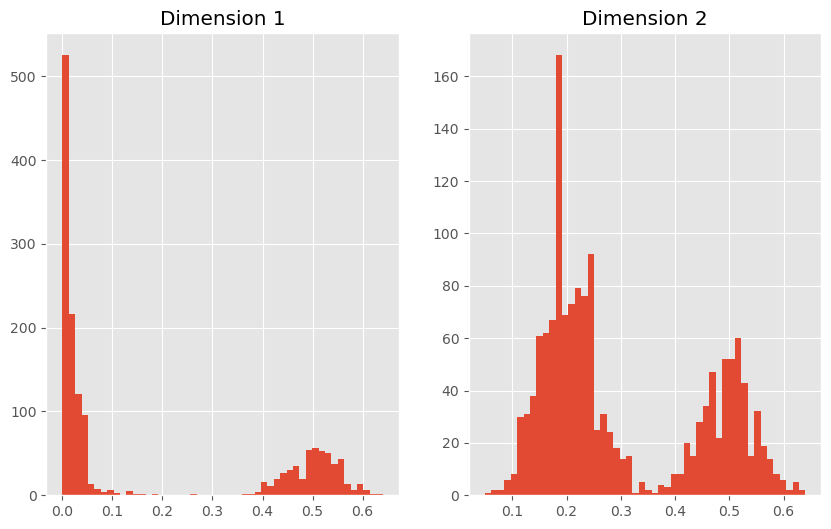

In [9]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [10]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

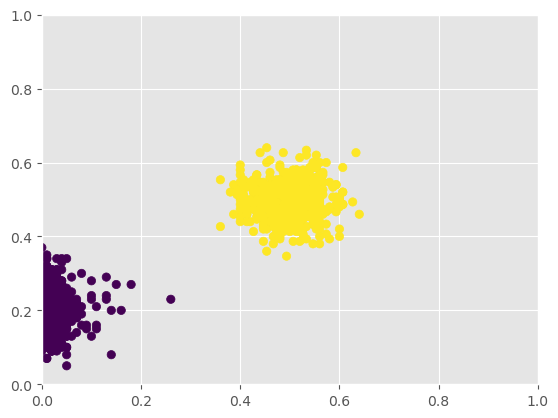

In [11]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

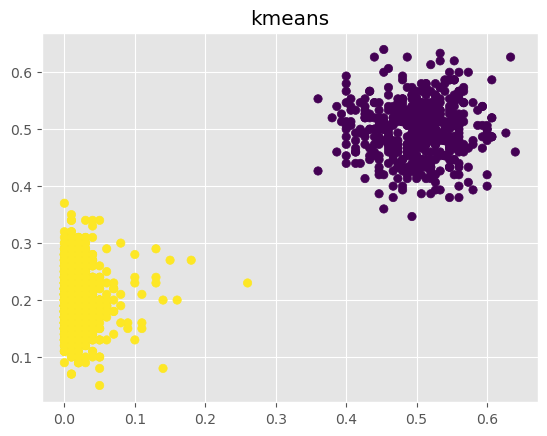

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.title("kmeans")

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Beta:  tensor([[0.5293, 0.5293],
        [1.3473, 0.7153]])
Pareto:  tensor([[-6.4497, -6.4244],
        [ 3.3633, -3.7040]])
Alpha:  tensor([[2., 2.],
        [2., 2.]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9900, 1.9900],
        [1.9900, 1.9900]], grad_fn=<AddBackward0>)
Iteration 0: Loss = 8071618.5
weights_param tensor([0.4247, 0.5753], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9816, 1.9815],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5019, 0.4979],
        [0.0192, 0.2022]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503],
        [5.0502, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.0982, 0.9018],
         [0.0982, 0.9018]],

        [[0.9018, 0.0982],
 

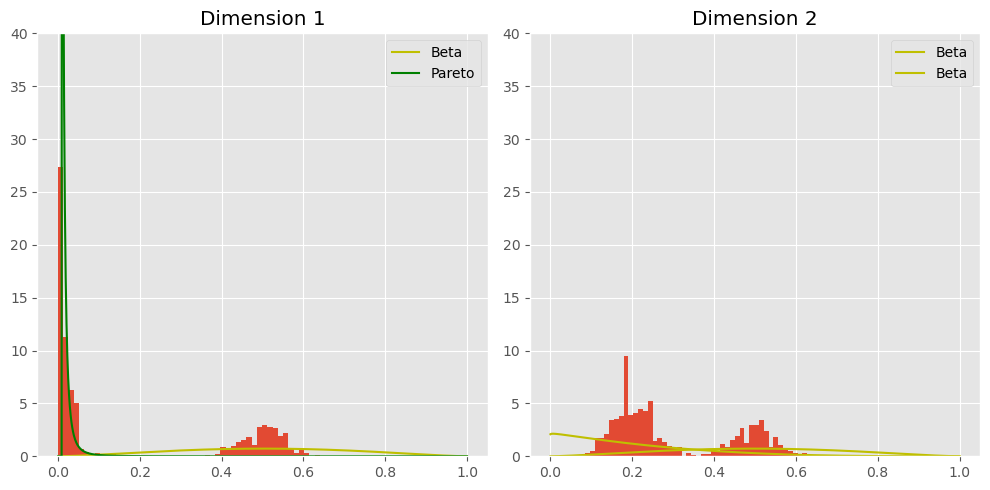

Alpha:  tensor([[1.9816, 1.9815],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9775, 1.9768],
        [1.9703, 1.9702]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9775, 1.9764],
        [1.9606, 1.9604]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9801, 1.9786],
        [1.9509, 1.9507]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9839, 1.9823],
        [1.9415, 1.9410]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9881, 1.9865],
        [1.9321, 1.9313]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9919, 1.9905],
        [1.9229, 1.9218]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9944, 1.9934],
        [1.9139, 1.9122]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9955, 1.9949],
        [1.9051, 1.9028]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9951, 1.9950],
        [1.8966, 1.8934]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9937, 1.9939],
        [1.8882, 1.8841]], grad_fn=<AddBackward0>)
Alpha:  tensor([[1.9916, 1.9920],
        [1.8802, 1.8749]], grad

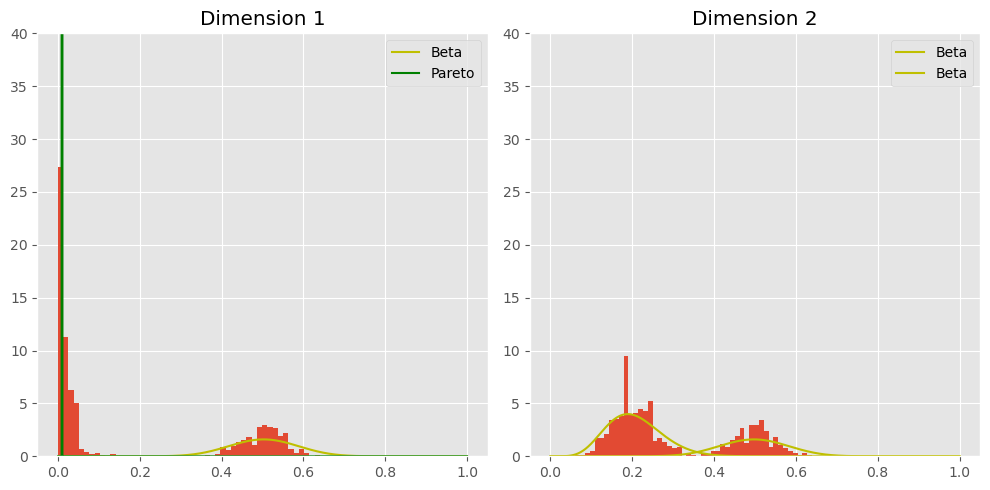

Alpha:  tensor([[  2.0121,   2.0094],
        [127.6907,   1.4361]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0121,   2.0094],
        [129.7125,   1.4375]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0122,   2.0093],
        [131.7701,   1.4389]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0123,   2.0092],
        [133.8650,   1.4401]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0125,   2.0092],
        [135.9988,   1.4412]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0126,   2.0091],
        [138.1725,   1.4421]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0126,   2.0096],
        [140.3878,   1.4426]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0126,   2.0102],
        [142.6473,   1.4428]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0127,   2.0105],
        [144.9526,   1.4425]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0128,   2.0102],
        [147.3057,   1.4417]], grad_fn=<AddBackward0>)
Alpha:  tensor([[  2.0129,   2.0098],
        [149.7100,   1.4402]], g

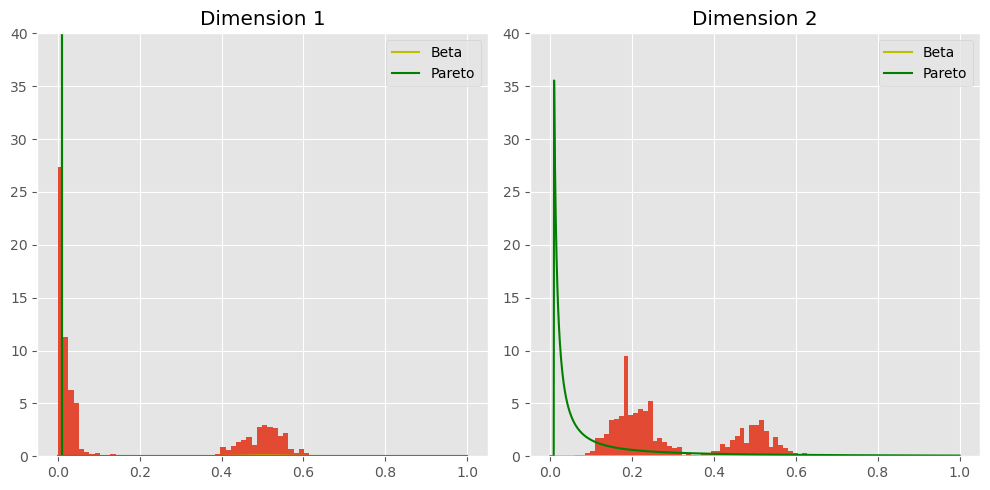

Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.2187e+05, 3.6041e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.2653e+05, 3.6040e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.3129e+05, 3.6039e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.3615e+05, 3.6038e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.4111e+05, 3.6037e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.4619e+05, 3.6036e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.5137e+05, 3.6035e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.5666e+05, 3.6034e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.6207e+05, 3.6033e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.6760e+05, 3.6032e-01]], grad_fn=<AddBa

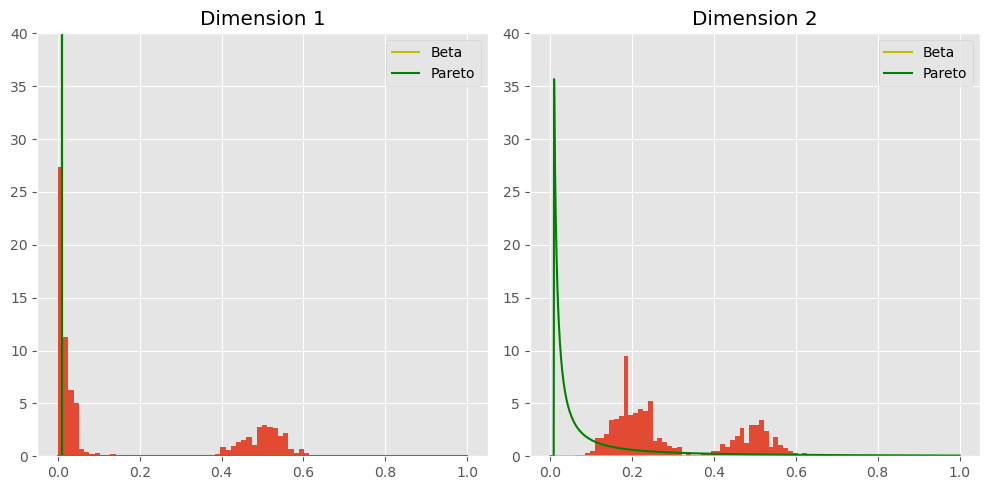

Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [1.8929e+09, 3.5879e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [1.9393e+09, 3.5879e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [1.9869e+09, 3.5879e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.0357e+09, 3.5879e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.0856e+09, 3.5879e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.1368e+09, 3.5878e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.1893e+09, 3.5878e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.2431e+09, 3.5878e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.2982e+09, 3.5878e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0134e+00],
        [2.3547e+09, 3.5877e-01]], grad_fn=<AddBa

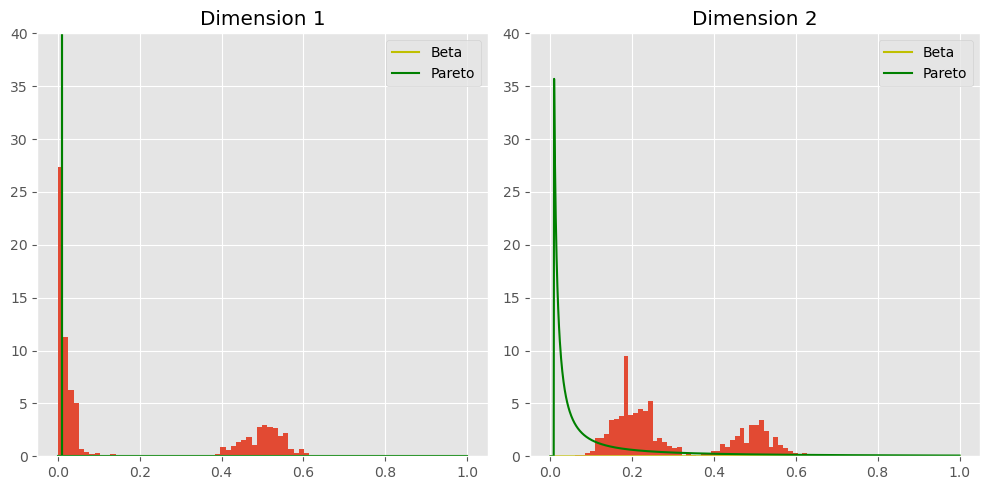

Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5814e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5813e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0135e+00, 2.0134e+00],
        [2.3635e+12, 3.5812e-01]], grad_fn=<AddBa

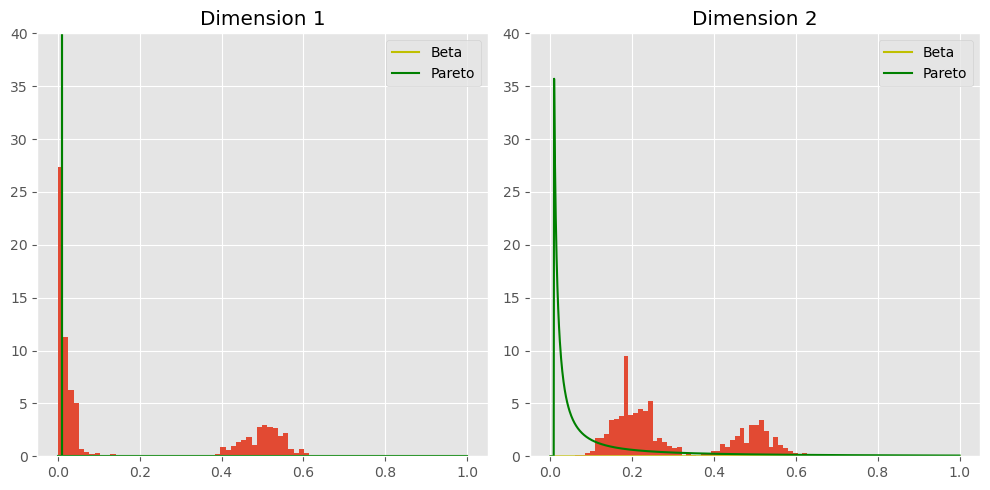

Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5780e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5780e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5780e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5780e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5780e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5779e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5779e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5779e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5779e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0136e+00],
        [2.3635e+12, 3.5779e-01]], grad_fn=<AddBa

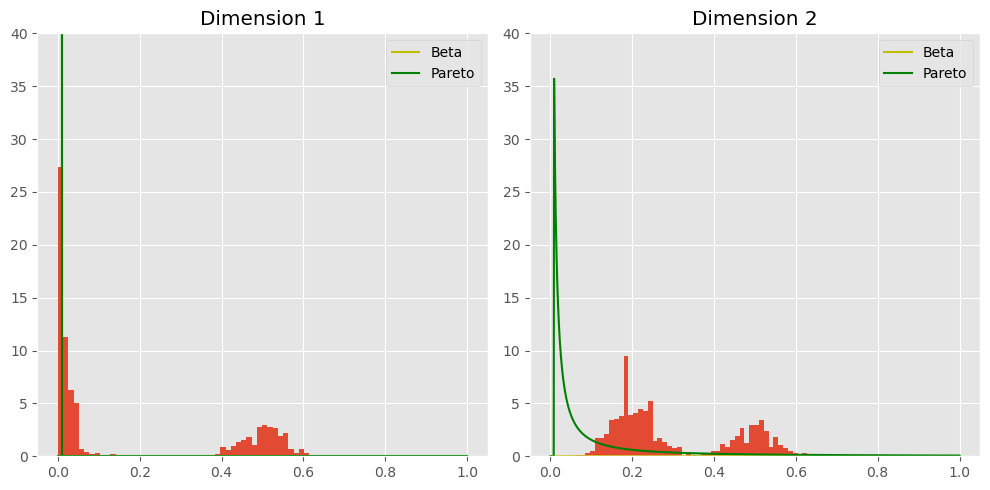

Alpha:  tensor([[2.0139e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0143e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0138e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0144e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0136e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0146e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0134e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0148e+00, 2.0138e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0132e+00, 2.0137e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0151e+00, 2.0138e+00],
        [2.3635e+12, 3.5760e-01]], grad_fn=<AddBa

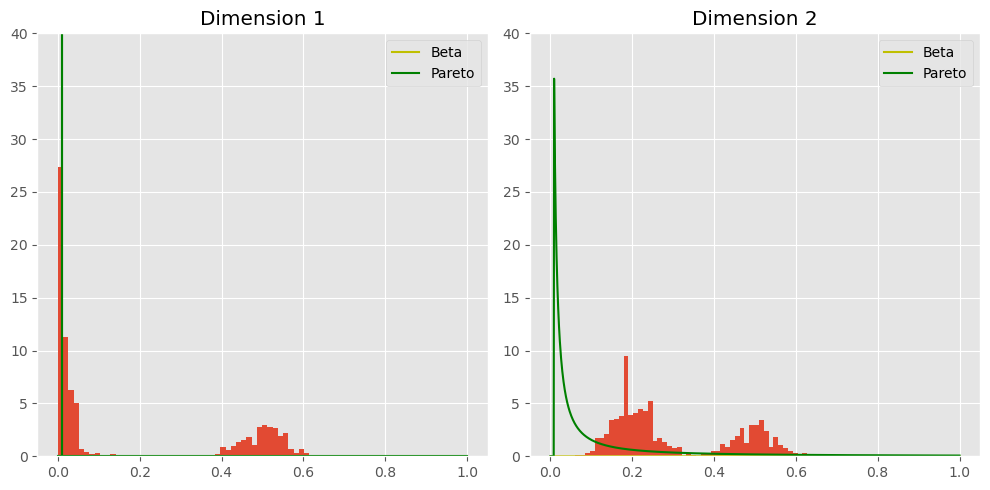

Alpha:  tensor([[2.0141e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0145e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0141e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0144e+00, 2.0139e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0143e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0142e+00, 2.0139e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0144e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0141e+00, 2.0139e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0145e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBackward0>)
Alpha:  tensor([[2.0142e+00, 2.0140e+00],
        [2.3635e+12, 3.5747e-01]], grad_fn=<AddBa

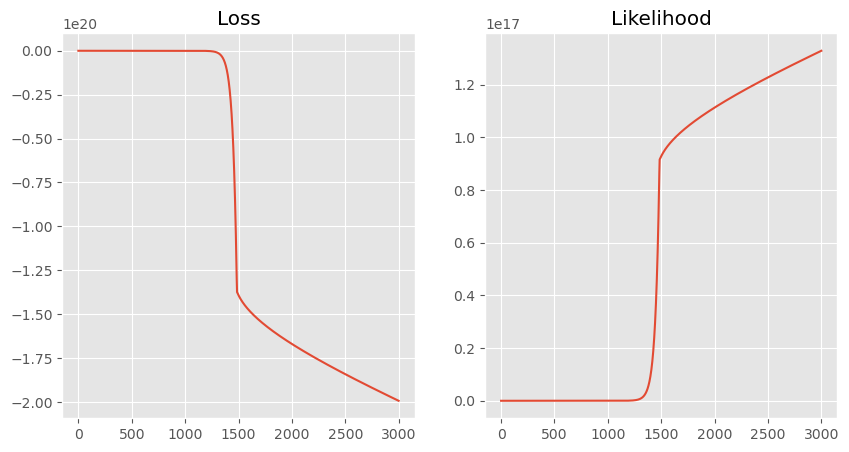

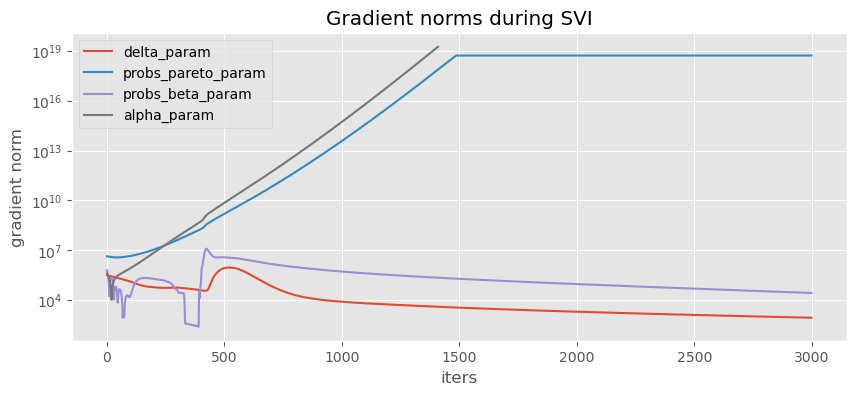

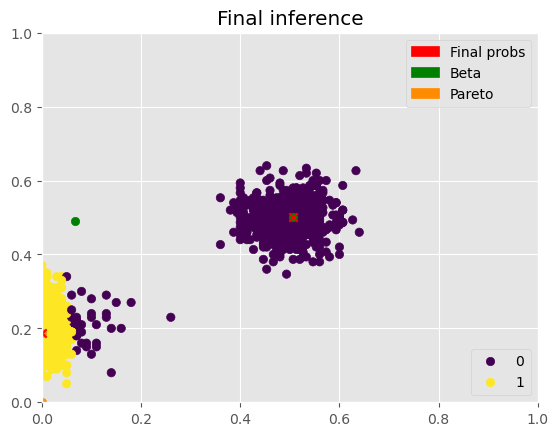

In [24]:
mb = mobster_MV(NV, DP, K = 2, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

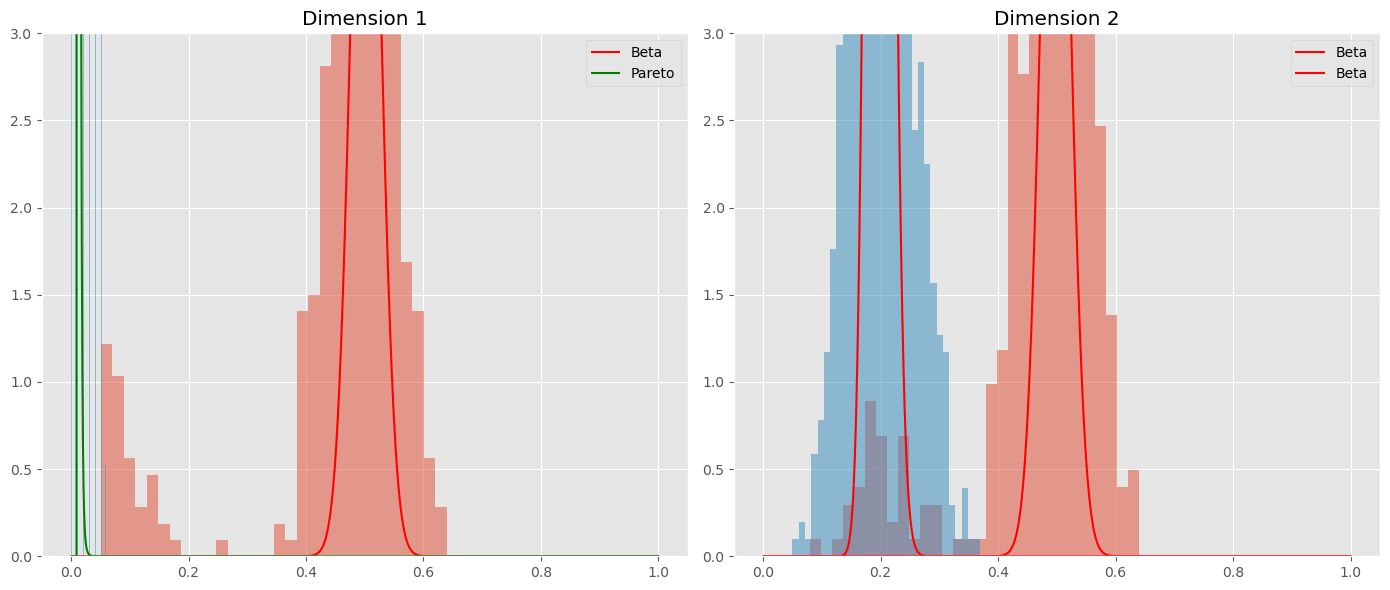

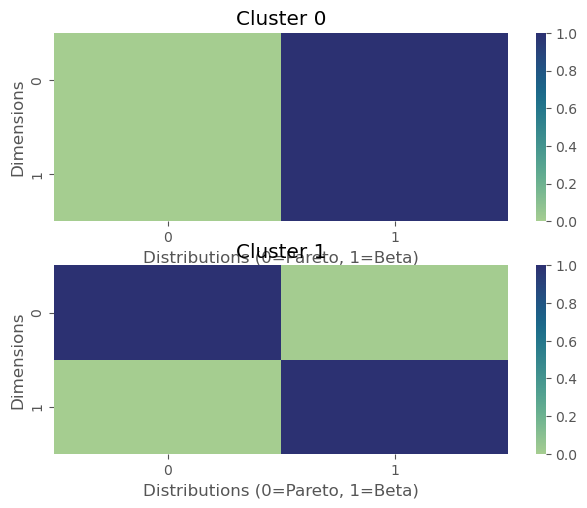

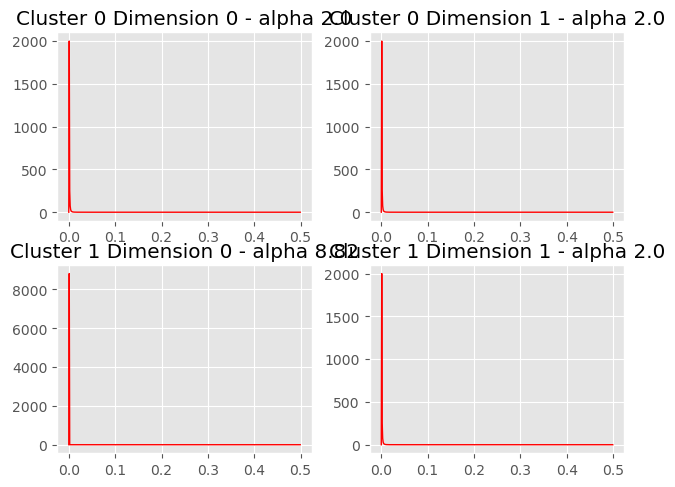

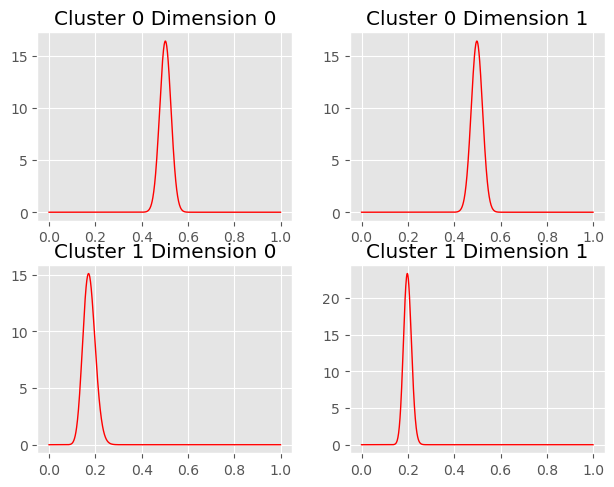

In [18]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [ ]:
mb.params

{'probs_beta': tensor([[0.5020, 0.4978],
         [0.1165, 0.1982]]),
 'probs_pareto': tensor([[2.3037e-01, 2.0138e-01],
         [3.5860e-10, 2.3408e-02]]),
 'weights': tensor([0.3333, 0.6667]),
 'delta': tensor([[[0.0021, 0.9979],
          [0.0021, 0.9979]],
 
         [[0.9777, 0.0223],
          [0.0026, 0.9974]]]),
 'alpha_pareto': tensor([[2.0000, 2.0000],
         [3.9999, 1.9999]]),
 'phi_beta': tensor([[0.5020, 0.4978],
         [0.1182, 0.1986]]),
 'k_beta': tensor([[422.2736, 422.2729],
         [218.8602, 544.2460]]),
 'responsib': tensor([[9.4485e-38, 2.4428e-35, 2.7094e-23,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### 3 beta-pareto components

In [4]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
N5 = 200
seed = 123
# Component 1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

# Component 5
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n5=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n5, N=N5, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


torch.Size([1200, 2])
torch.Size([1200, 2])


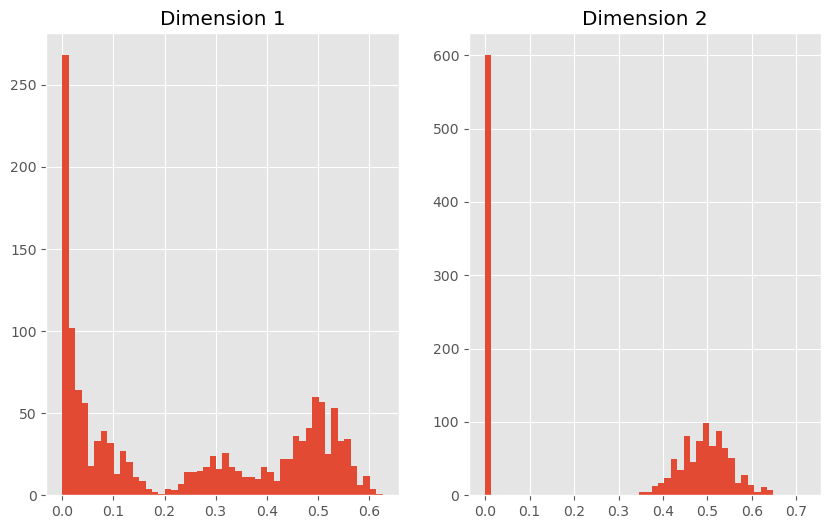

In [5]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N3)*4
labels = np.concatenate((labels, labels_5))

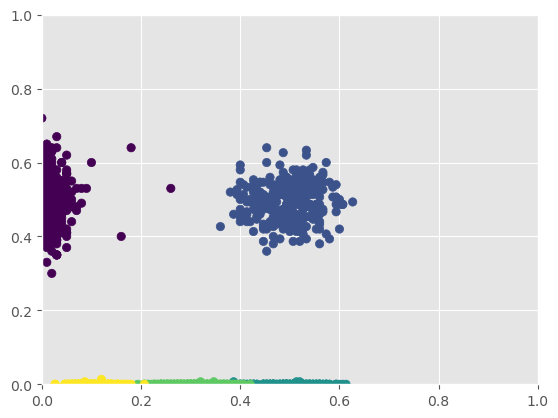

In [29]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8765e-05]])
inertia:  4.6338300704956055


(0.0, 1.0)

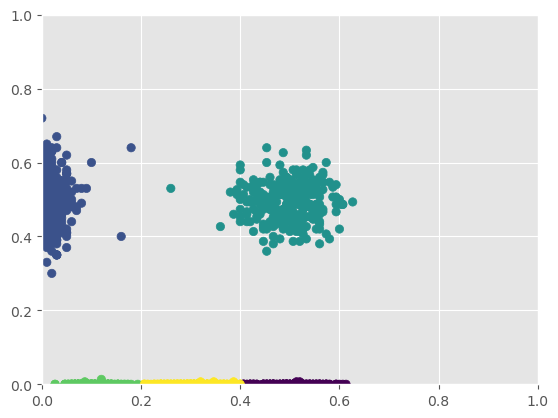

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[1.0017e-01, 9.9927e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [5.0059e-01, 6.8814e-05],
        [3.0538e-01, 9.6411e-05]])
inertia:  4.6314496994018555


(0.0, 1.0)

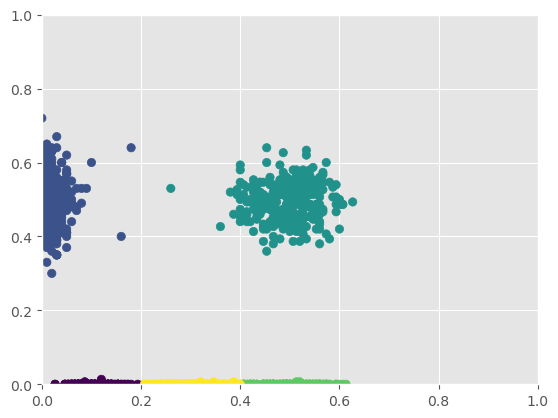

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=45, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8765e-05]])
Iteration 0: Loss = -10223122.0
weights_param tensor([0.1777, 0.2369, 0.0274, 0.2613, 0.2966], grad_fn=<DivBackward0>)
alpha_param tensor([[1.9995, 2.0040],
        [1.9961, 1.9994],
        [1.9995, 1.9995],
        [1.9983, 2.0040],
        [1.9994, 2.0040]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.9806e-01, 6.7190e-05],
        [1.8111e-02, 4.9717e-01],
        [4.9826e-01, 4.9503e-01],
        [1.0033e-01, 1.0013e-04],
        [3.0328e-01, 9.8963e-05]], grad_fn=<AddBackward0>)
k_beta_param tensor([[200.4004, 200.0520],
        [200.4004, 200.4004],
        [200.4004, 200.4004],
        [200.4004, 200.0521],
        [200.4004, 200.0521]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[4.9802e-01, 6.6921e-05],
        [1.8041e-02, 4.9713e-01],
        [4.9823e-01, 4.9503e-01],
        [

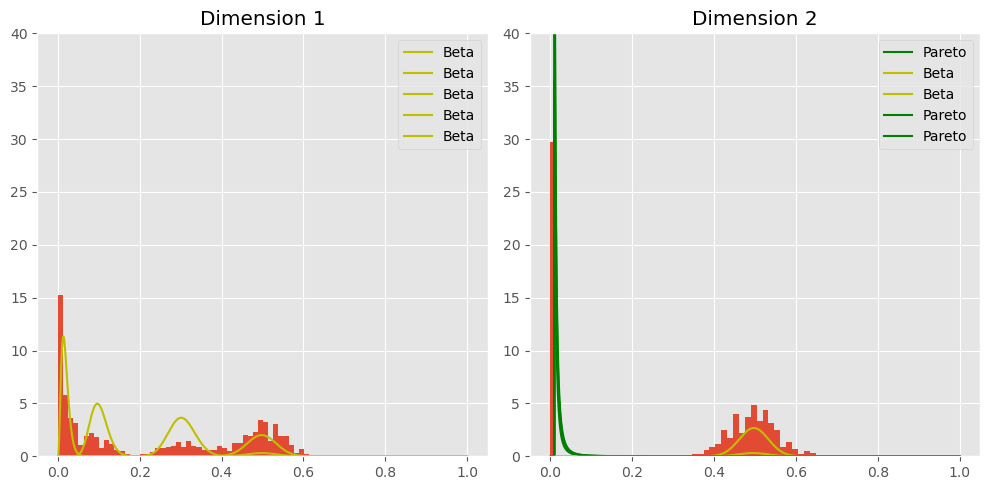

Iteration 200: Loss = -12638223.0
Iteration 400: Loss = -14177722.0
probs_beta [[4.9501154e-01 4.5082656e-05]
 [1.6214741e-02 4.9684620e-01]
 [4.9780542e-01 4.9524549e-01]
 [9.7344249e-02 6.7786517e-05]
 [2.9909024e-01 6.6980916e-05]]


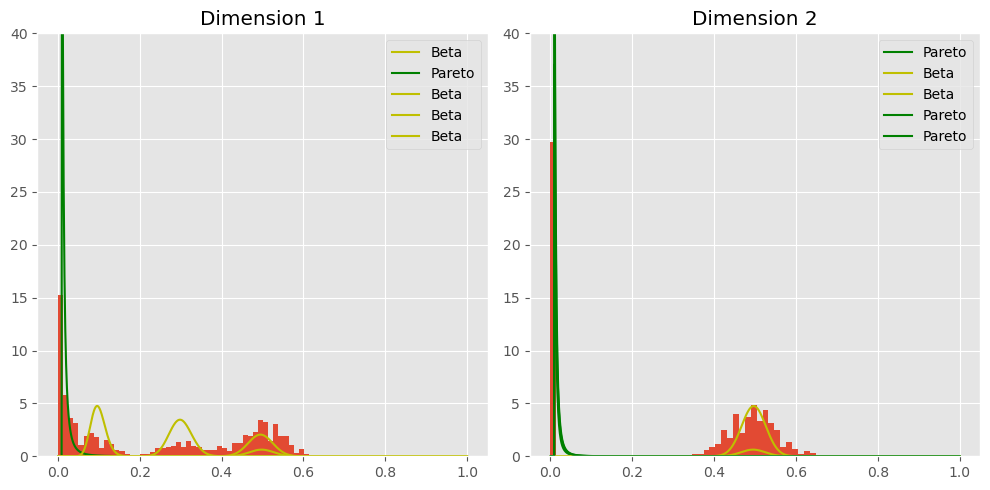

Iteration 600: Loss = -15612771.0
Iteration 800: Loss = -16877880.0
probs_beta [[4.9396566e-01 3.0379215e-05]
 [2.2116344e-02 4.9698177e-01]
 [4.9815059e-01 4.9509355e-01]
 [9.8127708e-02 4.5984154e-05]
 [2.9835823e-01 4.5425855e-05]]


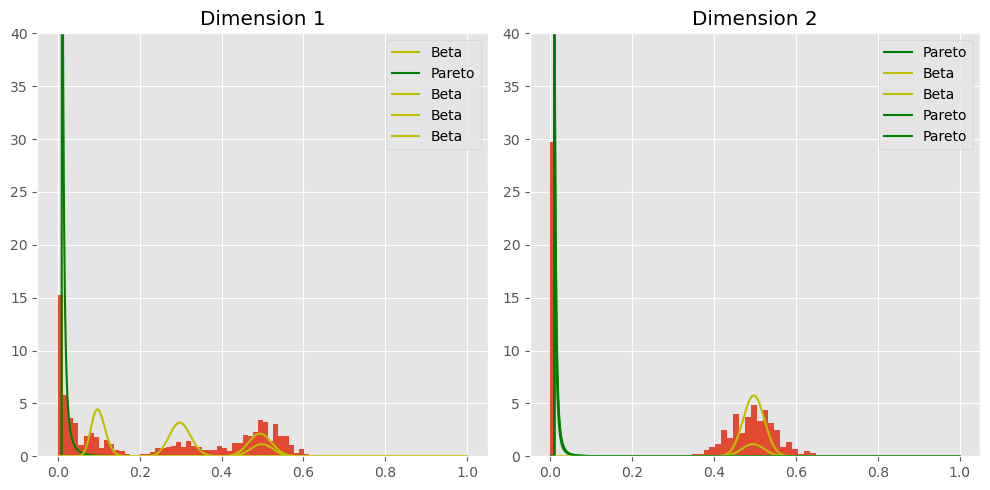

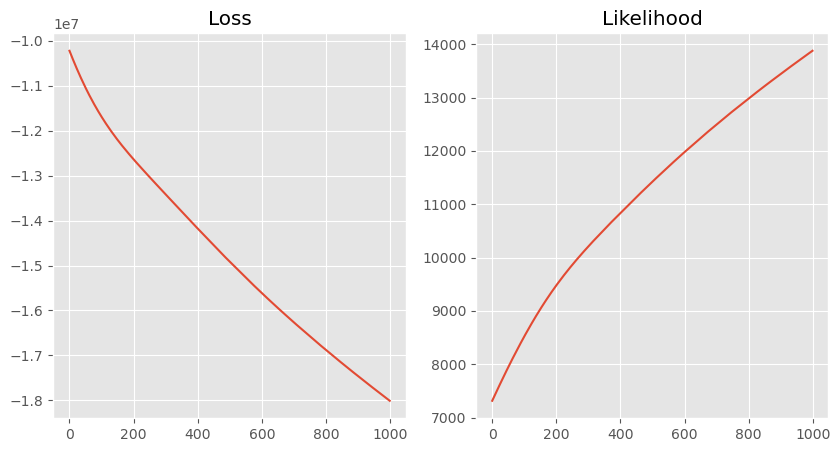

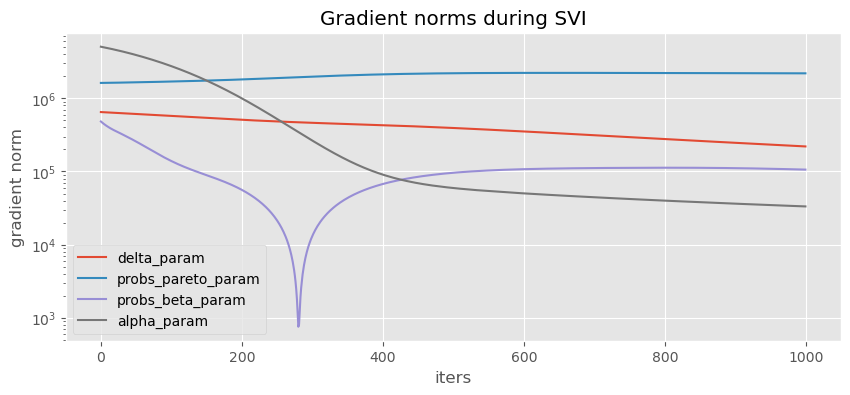

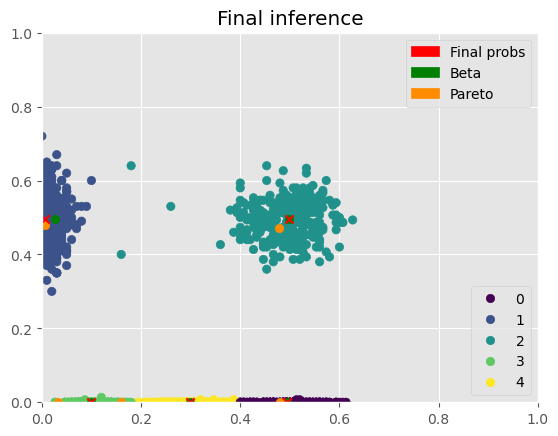

In [34]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 1000, lr = 0.001)

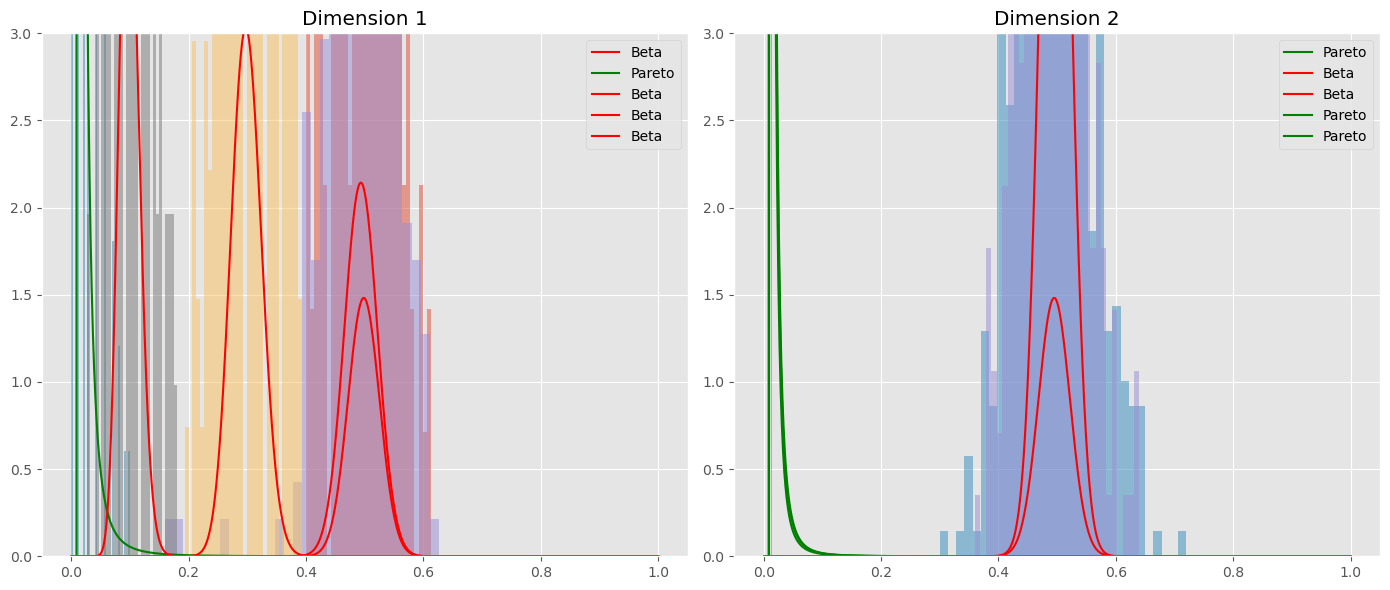

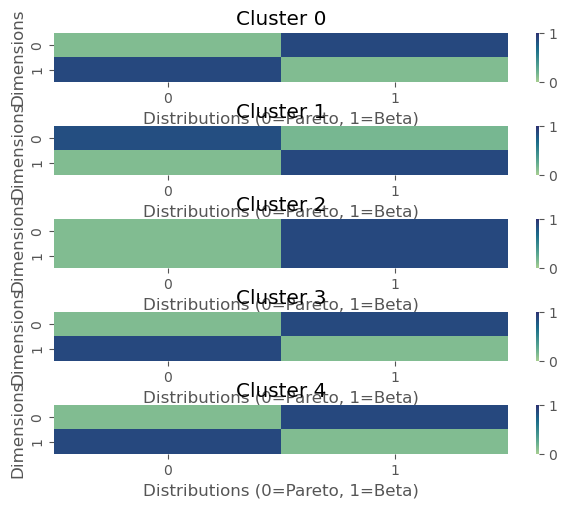

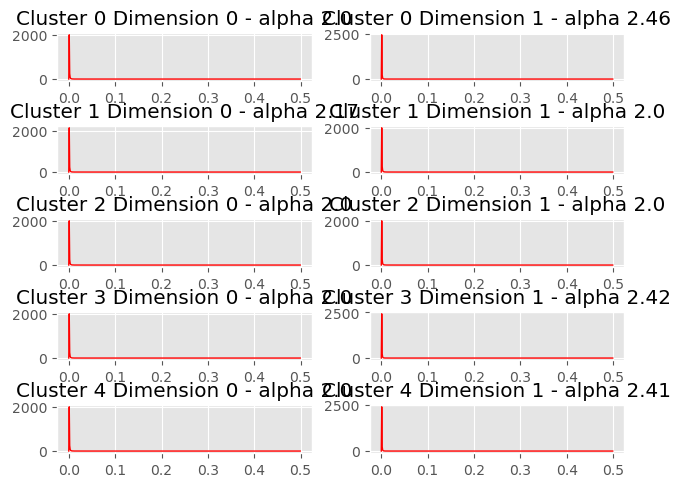

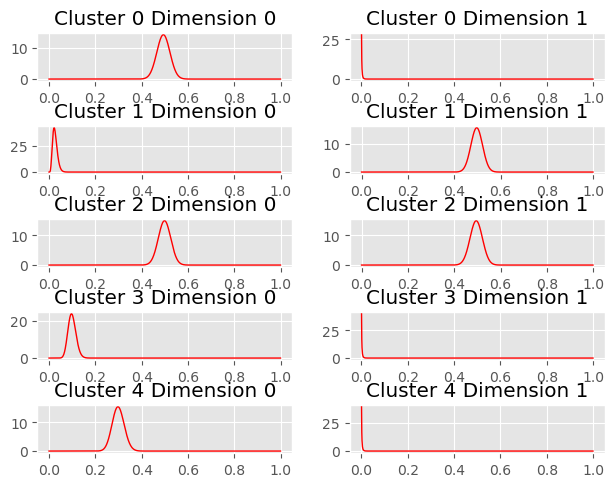

In [35]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [36]:
mb.params

{'probs_beta': tensor([[4.9351e-01, 2.4973e-05],
         [2.6384e-02, 4.9710e-01],
         [4.9844e-01, 4.9496e-01],
         [9.8102e-02, 3.7908e-05],
         [2.9801e-01, 3.7443e-05]]),
 'probs_pareto': tensor([[4.8000e-01, 2.3859e-05],
         [5.6410e-03, 4.7964e-01],
         [4.7873e-01, 4.7156e-01],
         [3.3422e-02, 3.5922e-05],
         [1.5914e-01, 3.5741e-05]]),
 'weights': tensor([0.1517, 0.3711, 0.0997, 0.1801, 0.1974]),
 'delta': tensor([[[0.1259, 0.8741],
          [0.8741, 0.1259]],
 
         [[0.8361, 0.1639],
          [0.1270, 0.8730]],
 
         [[0.1270, 0.8730],
          [0.1270, 0.8730]],
 
         [[0.1323, 0.8677],
          [0.8730, 0.1270]],
 
         [[0.1283, 0.8717],
          [0.8719, 0.1281]]]),
 'alpha_pareto': tensor([[2.0000, 2.4617],
         [2.1657, 2.0000],
         [2.0000, 2.0000],
         [1.9990, 2.4183],
         [1.9999, 2.4124]]),
 'phi_beta': tensor([[4.9353e-01, 1.7653e-04],
         [2.5879e-02, 4.9711e-01],
         [4.984

### With 3 beta components

In [ ]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.1, k_beta_x = 250, phi_beta_y = 0.1, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

In [ ]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

In [ ]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [ ]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [ ]:
mb = mobster_MV(NV, DP, K = 3, seed = 821)
mb.fit(num_iter = 3000, lr = 0.001)

In [ ]:
mb.params

In [ ]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### With 3 beta components (1 private)

In [ ]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.4, k_beta_x = 250, phi_beta_y = 0.0001, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

In [ ]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

In [ ]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [ ]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

In [ ]:
mb = mobster_MV(NV, DP, K = 3, seed = 48)
mb.fit(num_iter = 3000, lr = 0.001)

In [ ]:
mb.params

In [ ]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)